In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_inline(img, title="Image"):
    plt.figure(figsize=(10, 10))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()
def detect_board_contour(img, mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        print("No contours found!")
        return None

    # Sort contours by area, largest first
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    output_img = img.copy()

    # Loop over the top contours
    for i, cnt in enumerate(contours[:3]):
        # 1. Get the Convex Hull (The Blue line you liked)
        hull = cv2.convexHull(cnt)
        
        # We need to extract points from the hull array shape (N, 1, 2) -> (N, 2)
        hull_pts = hull[:, 0, :]

        # 2. Find the 4 Extreme Corners
        # We find corners by looking for the min/max sums and differences of (x, y)
        # This works even if the board is angled (trapezoid shape).
        
        # Top-Left: Minimal (x + y)
        sum_pts = hull_pts.sum(axis=1)
        tl_idx = np.argmin(sum_pts)
        
        # Bottom-Right: Maximal (x + y)
        br_idx = np.argmax(sum_pts)
        
        # Top-Right: Minimal (x - y)  (since y increases downwards)
        diff_pts = np.diff(hull_pts, axis=1)
        tr_idx = np.argmin(diff_pts)
        
        # Bottom-Left: Maximal (x - y)
        bl_idx = np.argmax(diff_pts)

        # Gather the 4 points
        corners = np.array([hull_pts[tl_idx], hull_pts[tr_idx], hull_pts[br_idx], hull_pts[bl_idx]])

        # 3. Validation: Area Check
        # Calculate the area of the shape formed by these 4 points
        # to ensure we didn't just pick noise.
        detected_area = cv2.contourArea(corners)
        
        if detected_area > 50000: # Adjust this threshold as needed
            print(f"Board detected (Contour #{i}) using Extreme Points!")
            
            # Draw the Hull (Blue)
            cv2.drawContours(output_img, [hull], -1, (255, 0, 0), 2)
            
            # Draw the 4 Detected Corners (Red Dots)
            for point in corners:
                cv2.circle(output_img, tuple(point), 20, (0, 0, 255), -1)
            
            # Draw the resulting box (Green) - It should now touch the corners exactly
            cv2.drawContours(output_img, [corners.reshape(-1, 1, 2)], -1, (0, 255, 0), 2)
            
            
            # Return shape (4, 2) for perspective transform
            return corners.reshape(4, 2)

    print("Could not find a large board.")
    return None
def detect_board(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    b_channel = lab[:, :, 2] 
    blur = cv2.GaussianBlur(b_channel, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 21, 2)
    
    
    _, mask = cv2.threshold(blur, 0, 255,cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))
    mask = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
    largest_contour = detect_board_contour(img, mask)
    return largest_contour
    

In [3]:

ref_board = cv2.imread('help/ref_pb.jpg')

def detect_game_components(img):
    map_contour_result = detect_board(img)
    main_board_area = cv2.contourArea(map_contour_result)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    blur = cv2.bilateralFilter(gray, 9, 75, 75)
    
    edged = cv2.Canny(blur, 30, 100)
    
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edged, kernel, iterations=2)
    if map_contour_result is not None:
        # Check if the result is already an integer array (contours must be int)
        board_cnt = map_contour_result.astype(np.int32)

        # Define how many pixels you want to expand outwards.
        # Note: The drawing thickness is centered on the line, so a thickness
        # of 20 expands outwards by roughly 10 pixels.
        margin_thickness = int(0.05 * np.sqrt(main_board_area)) 

        # 1. Draw a thick black outline to create the margin
        cv2.drawContours(dilated, [board_cnt], -1, 0, thickness=margin_thickness)
        
        # 2. Fill the inside with black
        # thickness=-1 fills the shape
        cv2.drawContours(dilated, [board_cnt], -1, 0, thickness=-1)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    player_board_contours = []
    remaining_contours = contours.copy()

    
    if map_contour_result is None:
        print("Could not detect the Main Map.")
        return img, None, []

    min_player_area = main_board_area * 0.05
    max_player_area = main_board_area * 0.70
    debug_img = img.copy()
    if remaining_contours:
        for c in remaining_contours:
            cv2.drawContours(debug_img, [c], -1, (0, 255, 255), 2)
            hull = cv2.convexHull(c)
            peri = cv2.arcLength(hull, True)
            
            approx = cv2.approxPolyDP(hull, 0.04 * peri, True)
            area = cv2.contourArea(hull)

            if len(approx) == 4 and min_player_area < area < max_player_area:
                M = cv2.moments(approx)
                if M["m00"] != 0:
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    
                    # pointPolygonTest returns positive if inside, negative if outside
                    player_board_contours.append(approx)
    

    return img, map_contour_result, player_board_contours

res,map_conts,player_conts = detect_game_components(cv2.imread('maps/mapa21.jpg'))
for pc in player_conts:
    cv2.drawContours(res, [pc], -1, (255, 0, 0), 4)
cv2.drawContours(res, [map_conts], -1, (0, 255, 0), 4)

Board detected (Contour #0) using Extreme Points!


array([[[122, 137, 146],
        [100, 115, 124],
        [ 86, 101, 110],
        ...,
        [ 67,  71,  76],
        [ 65,  69,  74],
        [ 64,  68,  73]],

       [[118, 133, 142],
        [ 98, 113, 122],
        [ 88, 103, 112],
        ...,
        [ 68,  72,  77],
        [ 66,  70,  75],
        [ 65,  69,  74]],

       [[112, 127, 136],
        [ 96, 111, 120],
        [ 91, 106, 115],
        ...,
        [ 68,  72,  77],
        [ 67,  71,  76],
        [ 66,  70,  75]],

       ...,

       [[ 75,  86,  90],
        [ 74,  85,  89],
        [ 73,  84,  88],
        ...,
        [  2,   0,   0],
        [  6,   1,   2],
        [  9,   4,   5]],

       [[ 74,  85,  89],
        [ 73,  84,  88],
        [ 72,  83,  87],
        ...,
        [  2,   0,   0],
        [  4,   0,   0],
        [  6,   1,   2]],

       [[ 73,  84,  88],
        [ 72,  83,  87],
        [ 71,  82,  86],
        ...,
        [  2,   0,   0],
        [  4,   0,   0],
        [  4,   0,   0]]

In [4]:

def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)] 
    rect[2] = pts[np.argmax(s)] 
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)] 
    rect[3] = pts[np.argmax(diff)] 
    return rect

def auto_correct_orientation(img):
    """
    Rotates the board so the Thermometer (Blue/Red strip) is at the bottom.
    Heuristic: The -30C zone is BLUE and should be at the Bottom-Left of the inner map.
    """
    best_img = img
    max_score = -1
    best_angle = 0
    
    h, w = img.shape[:2]
    roi_y1, roi_y2 = int(h * 0.62), int(h * 0.84)
    roi_x1, roi_x2 = int(w * 0.80), int(w * 0.95)
    
    for angle in [0, 90, 180, 270]:
        rotated = img.copy()
        if angle == 90:
            rotated = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        elif angle == 180:
            rotated = cv2.rotate(img, cv2.ROTATE_180)
        elif angle == 270:
            rotated = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
            
        roi = rotated[roi_y1:roi_y2, roi_x1:roi_x2]
        hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
        
        lower_blue = np.array([90, 50, 50])
        upper_blue = np.array([130, 255, 255])
        mask = cv2.inRange(hsv_roi, lower_blue, upper_blue)
        
        score = cv2.countNonZero(mask)
        
        
        if score > max_score:
            max_score = score
            best_img = rotated
            best_angle = angle

    print(f"Auto-Rotation applied: {best_angle} degrees (Score: {max_score})")
    return best_img

def isolate_score_track(img, board_contour):
    if img is None or board_contour is None:
        print("Missing input data.")
        return None, None

    rect = order_points(board_contour.reshape(4, 2))
    warped_size = 1000
    dst = np.array([
        [0, 0],
        [warped_size - 1, 0],
        [warped_size - 1, warped_size - 1],
        [0, warped_size - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(img, M, (warped_size, warped_size))
    
    warped = auto_correct_orientation(warped)

    inner_ratio = 46 / 52
    margin_percentage = (1.0 - inner_ratio) / 2.0
    margin_px = int(warped_size * margin_percentage)

    mask = np.zeros((warped_size, warped_size), dtype="uint8")
    
    cv2.rectangle(mask, (0, 0), (warped_size, warped_size), 255, -1)
    
    cv2.rectangle(mask,
                  (margin_px, margin_px),
                  (warped_size - margin_px, warped_size - margin_px),
                  0, -1)

    track_only = cv2.bitwise_and(warped, warped, mask=mask)

    
    return track_only, warped




In [5]:

def crop_floor_by_lab(image):
    if image is None: return None
    
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    b_channel = lab[:, :, 2] 
    blur = cv2.GaussianBlur(b_channel, (5, 5), 0)
    target_percentile = 90    
    dynamic_thresh_val = np.percentile(blur, target_percentile)
    
    
    thresh = cv2.threshold(blur, dynamic_thresh_val, 255, cv2.THRESH_BINARY)[1]
    _, mask = cv2.threshold(blur, 0, 255,cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
    return mask
        



In [6]:

def refine_mask(mask):

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    
    contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    valid_contours = [c for c in contours if cv2.contourArea(c) > 30]
    
    if not valid_contours:
        print("No contours found.")
        return opened

    rects = []
    centers = []
    for c in valid_contours:
        x, y, w, h = cv2.boundingRect(c)
        rects.append((x, y, w, h))
        centers.append([x + w//2, y + h//2])

    all_dims = [r[2] for r in rects] + [r[3] for r in rects]
    median_side = np.median(all_dims)
    median_area = np.median([r[2]*r[3] for r in rects])

    centers = np.array(centers)
    if len(centers) > 1:
        diffs = centers[:, np.newaxis, :] - centers[np.newaxis, :, :]
        dists = np.sqrt(np.sum(diffs**2, axis=-1))
        
        np.fill_diagonal(dists, np.inf)
        
        nearest_dists = np.min(dists, axis=1)
        median_pitch = np.median(nearest_dists)
    else:
        median_pitch = median_side * 1.2 

    print(f"Stats -> Pad Size: {median_side:.1f} | Pitch (Pad+Gap): {median_pitch:.1f}")

    final_mask = opened.copy()
    median_width = np.median([r[2] for r in rects])
    median_height = np.median([r[3] for r in rects])
    for c in valid_contours:
        area = cv2.contourArea(c)
        x, y, w, h = cv2.boundingRect(c)
        
        if area < 0.45 * median_area:
            cv2.drawContours(final_mask, [c], -1, 0, -1)
            continue
        
        if area > 1.5 * median_area:
            
            if w > h: 
                count = int(round(w / median_pitch))
                count = max(2, count)
                
                step = w / count
                for i in range(1, count):
                    split_x = int(x + (i * step))
                    cv2.line(final_mask, (split_x, y), (split_x, y+h), 0, thickness=4)
                    
            else:
                count = int(round(h / median_pitch))
                count = max(2, count)
                
                step = h / count
                for i in range(1, count):
                    split_y = int(y + (i * step))
                    cv2.line(final_mask, (x, split_y), (x+w, split_y), 0, thickness=4)
        if w < 0.6 * median_width or h < 0.6 * median_height:
            cv2.drawContours(final_mask, [c], -1, 0, -1)
            continue    
    return final_mask



In [7]:
def repair_mask(image_path_or_array, total_pads=100):
    # 1. Load and Threshold
    if isinstance(image_path_or_array, str):
        img = cv2.imread(image_path_or_array, cv2.IMREAD_GRAYSCALE)
    else:
        img = image_path_or_array

    _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    repaired_mask = thresh.copy()
    debug_vis = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 2. Filter Contours (Dynamic Threshold)
    all_areas = [cv2.contourArea(c) for c in contours]
    if not all_areas: return img, debug_vis
    median_area = np.median(all_areas)

    pad_rects = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if w * h > (0.2 * median_area): # Permissive filter
            pad_rects.append({'cx': x + w//2, 'cy': y + h//2, 'w': w, 'h': h})

    if not pad_rects: return img, debug_vis

    # 3. Robust Rail Detection (Histogram Method)
    # We look for the X and Y coordinates that have the most "votes" (pads aligned there).
    
    # Extract all X and Y coordinates
    all_cx = [p['cx'] for p in pad_rects]
    all_cy = [p['cy'] for p in pad_rects]

    # Helper to find peaks
    def find_peaks(coords, tolerance):
        # We bin the coordinates and find the two most populated bins
        # Bin size is roughly the size of a pad (tolerance)
        bins = []
        for val in coords:
            # Check if this value belongs to an existing bin
            found_bin = False
            for b in bins:
                if abs(np.mean(b) - val) < tolerance:
                    b.append(val)
                    found_bin = True
                    break
            if not found_bin:
                bins.append([val])
        
        # Sort bins by population (count of pads)
        sorted_bins = sorted(bins, key=len, reverse=True)
        
        # We expect the top 2 bins to be the two parallel rails (e.g., Left and Right)
        # We take the mean of those bins as the rail coordinate
        if len(sorted_bins) < 2:
            return min(coords), max(coords) # Fallback
            
        peak1 = int(np.mean(sorted_bins[0]))
        peak2 = int(np.mean(sorted_bins[1]))
        
        return sorted([peak1, peak2]) # Return [Min_Rail, Max_Rail]

    median_w = np.median([p['w'] for p in pad_rects])
    median_h = np.median([p['h'] for p in pad_rects])

    # Find the Rails (ignoring outliers/missing corners)
    # Tolerance is half a pad size roughly
    rail_left, rail_right = find_peaks(all_cx, median_w)
    rail_top, rail_bottom = find_peaks(all_cy, median_h)

    print(f"Detected Rails | X: {rail_left}, {rail_right} | Y: {rail_top}, {rail_bottom}")

    # 4. Define Corners from Rails
    tl = (rail_left,  rail_top)
    tr = (rail_right, rail_top)
    br = (rail_right, rail_bottom)
    bl = (rail_left,  rail_bottom)

    # 5. Interpolate Ideal Grid
    pads_per_side = int(total_pads / 4) + 1 
    ideal_points = []

    def get_linspace(start_pt, end_pt, count):
        pts = []
        for i in range(count):
            t = i / (count - 1)
            x = int(start_pt[0] + (end_pt[0] - start_pt[0]) * t)
            y = int(start_pt[1] + (end_pt[1] - start_pt[1]) * t)
            pts.append((x, y))
        return pts

    ideal_points.extend(get_linspace(tl, tr, pads_per_side))       # Top
    ideal_points.extend(get_linspace(tr, br, pads_per_side)[1:])   # Right
    ideal_points.extend(get_linspace(br, bl, pads_per_side)[1:])   # Bottom
    ideal_points.extend(get_linspace(bl, tl, pads_per_side)[1:-1]) # Left

    # 6. Draw Missing Pads
    pads_drawn = 0
    draw_w = int(median_w - 2)
    draw_h = int(median_h - 2)

    for (ix, iy) in ideal_points:
        match_found = False
        for p in pad_rects:
            # Check if existing pad is nearby
            if abs(p['cx'] - ix) < (median_w / 1.5) and abs(p['cy'] - iy) < (median_h / 1.5):
                match_found = True
                break
        
        if not match_found:
            tl_x = int(ix - draw_w // 2)
            tl_y = int(iy - draw_h // 2)
            cv2.rectangle(repaired_mask, (tl_x, tl_y), (tl_x + draw_w, tl_y + draw_h), 255, -1)
            cv2.rectangle(debug_vis, (tl_x, tl_y), (tl_x + draw_w, tl_y + draw_h), (0, 255, 0), -1)
            pads_drawn += 1
    
    print(f"Repaired {pads_drawn} missing pads.")
    return repaired_mask, debug_vis

In [8]:
import math

def process_chip_grid(original_img_path, mask_img_path):
     original = original_img_path
     vis = original.copy()
     mask = mask_img_path
     _, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
     contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
     
     pads = []
     for c in contours:
         x, y, w, h = cv2.boundingRect(c)
         if w * h > 50: 
            pads.append({'x': x, 'y': y, 'w': w, 'h': h, 'cx': x + w//2, 'cy': y + h//2, 'real': True})
     if pads:
         pads.sort(key=lambda p: p['cx']) 
         med_w = np.median([p['w'] for p in pads])
         med_h = np.median([p['h'] for p in pads])
     all_cx = [p['cx'] for p in pads]
     all_cy = [p['cy'] for p in pads]
     grid_cx = np.mean(all_cx)
     grid_cy = np.mean(all_cy)
     for p in pads:
         p['angle'] = math.atan2(p['cy'] - grid_cy, p['cx'] - grid_cx)
     pads.sort(key=lambda p: p['angle'])
     dist_to_tl = [p['cx'] + p['cy'] for p in pads]
     start_index = np.argmin(dist_to_tl)
     ordered_pads = pads[start_index:] + pads[:start_index]
     yellow_group = []
     orange_group = []
     for i, p in enumerate(ordered_pads):
         x, y, w, h = p['x'], p['y'], p['w'], p['h']
         is_yellow = (i % 5 == 0)
         if is_yellow:
             yellow_group.append(p)
             color = (0, 255, 255) 
             thick = 3
             roi = original[y:y+h, x:x+w]
         else:
             orange_group.append(p)
             color = (0, 165, 255) 
             thick = 1

 
     return vis, ordered_pads




In [9]:
import cv2
import numpy as np

def normalize_board_colors_robust(original_img, pad_data):
    """
    Recolors 'Yellow' (Beige) pads to look like their 'Orange' neighbors.
    Uses a robust HSV range that catches pale/beige yellows while strictly
    protecting Green/Blue/Red chips.
    """
    normalized_img = original_img.copy()
    count = len(pad_data)

    # Convert the whole image to HSV once for efficiency
    hsv_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2HSV)

    for i, p in enumerate(pad_data):
        # Only process Yellow pads (0, 5, 10...)
        if i % 5 != 0:
            continue
            
        # 1. Get Neighbors to find Target Orange Color
        prev_idx = (i - 1) % count
        next_idx = (i + 1) % count
        prev_pad = pad_data[prev_idx]
        next_pad = pad_data[next_idx]

        roi_prev = original_img[prev_pad['y']:prev_pad['y']+prev_pad['h'], prev_pad['x']:prev_pad['x']+prev_pad['w']]
        roi_next = original_img[next_pad['y']:next_pad['y']+next_pad['h'], next_pad['x']:next_pad['x']+next_pad['w']]

        if roi_prev.size == 0 or roi_next.size == 0: continue

        # Calculate Target Orange (average of neighbors) in BGR
        color_prev = np.median(roi_prev, axis=(0,1)).astype(np.uint8)
        color_next = np.median(roi_next, axis=(0,1)).astype(np.uint8)
        target_orange_bgr = np.mean([color_prev, color_next], axis=0).astype(np.uint8)

        # 2. Process Current Pad
        x, y, w, h = p['x'], p['y'], p['w'], p['h']
        roi_bgr = normalized_img[y:y+h, x:x+w]
        roi_hsv = hsv_img[y:y+h, x:x+w] # Use the pre-converted HSV

        if roi_bgr.size == 0: continue

        # --- ROBUST MASKING STRATEGY ---
        
        # DEFINITION OF "BOARD YELLOW/BEIGE" (OpenCV Hue is 0-180)
        # Hue 10-45 covers everything from Orange-Yellow to Greenish-Yellow.
        # Green cubes usually start around Hue 55-60.
        lower_yellow = np.array([10, 20, 60])   # Saturation > 20 (Pale), Value > 60 (Not Black)
        upper_yellow = np.array([35, 255, 255]) # Hue < 45 (Stops before Green)

        # Create mask
        bg_mask = cv2.inRange(roi_hsv, lower_yellow, upper_yellow)
        
        # Clean up mask (remove isolated noise pixels)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        bg_mask = cv2.morphologyEx(bg_mask, cv2.MORPH_OPEN, kernel, iterations=1)

        # SAFETY CHECK:
        # If the mask is empty (0 pixels), our range missed. 
        # This usually means the tile is in shadow or very desaturated.
        # Fallback: Relax the Saturation requirement.
        if cv2.countNonZero(bg_mask) < (w * h * 0.1): # Less than 10% coverage
            # Try again with even lower saturation/value
            lower_relaxed = np.array([10, 5, 40]) 
            bg_mask = cv2.inRange(roi_hsv, lower_relaxed, upper_yellow)

        # 3. Apply Color Swap
        # Only paint over pixels that match our "Yellow/Beige" definition.
        # Green cubes (Hue ~60+) will be ignored.
        roi_bgr[bg_mask == 255] = target_orange_bgr

        # Save back
        normalized_img[y:y+h, x:x+w] = roi_bgr

    return normalized_img

# --- Usage ---
# normalized_vis = normalize_board_colors_robust(vis_original, ordered_pads)
# result_img, anomalies = detect_anomalies_top_n(normalized_vis, ordered_pads, period=1, neighbor_count=2, top_n=5)



In [10]:
import cv2
import numpy as np
import math

def detect_anomalies_top_n(original_img, pad_data, neighbor_count=3, top_n=5):
    vis = original_img.copy()

    # 1. Calculate HSV for EVERY pad
    for p in pad_data:
        x, y, w, h = p['x'], p['y'], p['w'], p['h']
        roi = original_img[y+2:y+h-2, x+2:x+w-2] 
        
        if roi.size > 0:
            mean_bgr = np.mean(roi, axis=(0,1))
            p['hsv'] = cv2.cvtColor(np.uint8([[mean_bgr]]), cv2.COLOR_BGR2HSV)[0][0]
        else:
            p['hsv'] = np.array([0, 0, 0])

    all_scored_pads = []
    count = len(pad_data)

    # 2. Score with Weighted Euclidean Distance
    for i, pad in enumerate(pad_data):
        current_color = pad['hsv'].astype(float)
        
        neighbors_hsv = []
        for offset in range(1, neighbor_count + 1):
            prev_idx = (i - offset) % count
            next_idx = (i + offset) % count
            neighbors_hsv.append(pad_data[prev_idx]['hsv'].astype(float))
            neighbors_hsv.append(pad_data[next_idx]['hsv'].astype(float))
        
        local_mean = np.mean(neighbors_hsv, axis=0)
        
        # Calculate raw differences
        diff_h = abs(current_color[0] - local_mean[0])
        diff_s = abs(current_color[1] - local_mean[1])
        diff_v = abs(current_color[2] - local_mean[2])
        
        # Handle Hue Wraparound (Red at 0 and Red at 180 are close)
        diff_h = min(diff_h, 180 - diff_h)

        # --- KEY CHANGE: WEIGHTS ---
        # Hue (Color) gets 4x weight -> Crucial for Green vs Orange
        # Saturation gets 1x weight -> Normal importance
        # Value (Brightness) gets 0.5x weight -> Ignores shadows/glare
        w_h, w_s, w_v = 4.0, 1.0, 0.5
        
        deviation_score = math.sqrt((diff_h * w_h)**2 + (diff_s * w_s)**2 + (diff_v * w_v)**2)
        
        pad['deviation'] = deviation_score
        all_scored_pads.append(pad)

    # 3. Sort and Visualize
    all_scored_pads.sort(key=lambda x: x['deviation'], reverse=True)
    top_guesses = all_scored_pads[:top_n]

    print(f"--- Top {top_n} Anomalies (Hue Weighted) ---")
    for rank, p in enumerate(top_guesses):
        x, y, w, h = p['x'], p['y'], p['w'], p['h']
        score = p['deviation']
        
        print(f"#{rank+1}: Score {score:.2f} at ({x}, {y})")
        
        cv2.rectangle(vis, (x, y), (x+w, y+h), (0, 0, 255), 3)
        label = f"#{rank+1} ({int(score)})"
        cv2.putText(vis, label, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)
    
    return vis, top_guesses

Board detected (Contour #0) using Extreme Points!
Auto-Rotation applied: 270 degrees (Score: 6637)


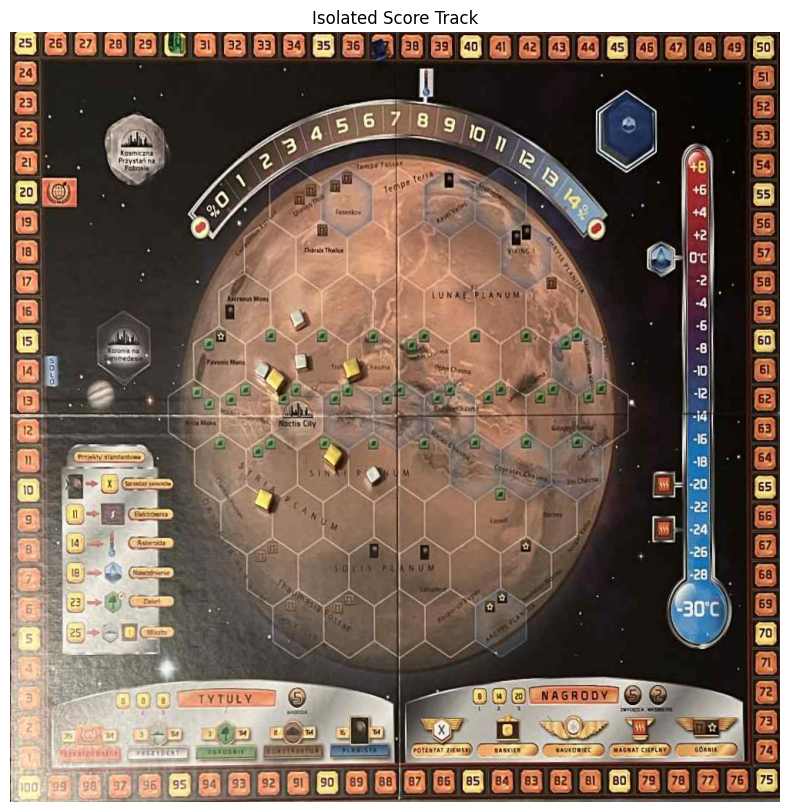

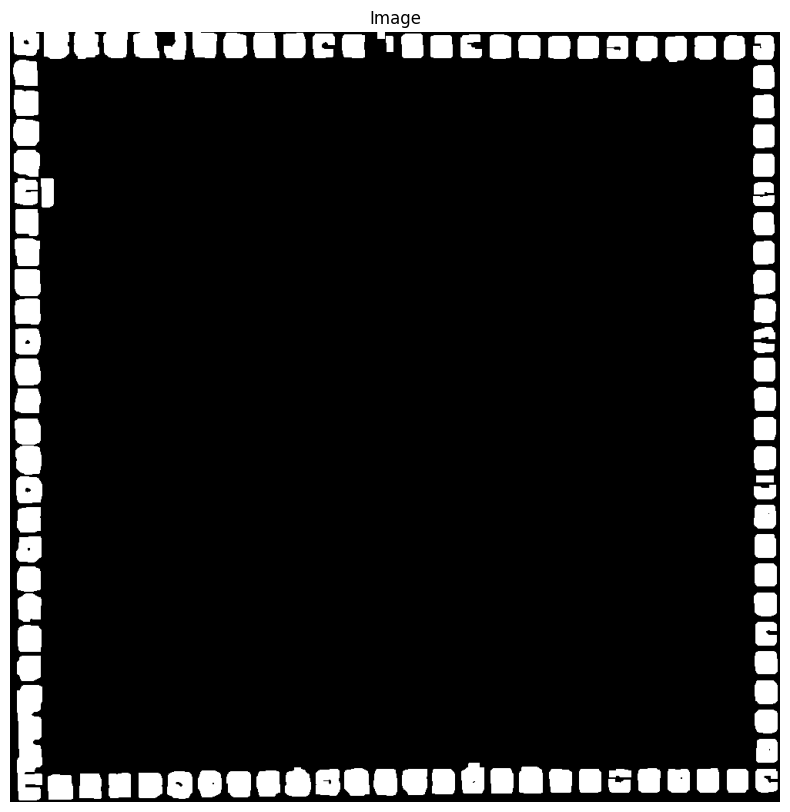

Stats -> Pad Size: 31.0 | Pitch (Pad+Gap): 38.0


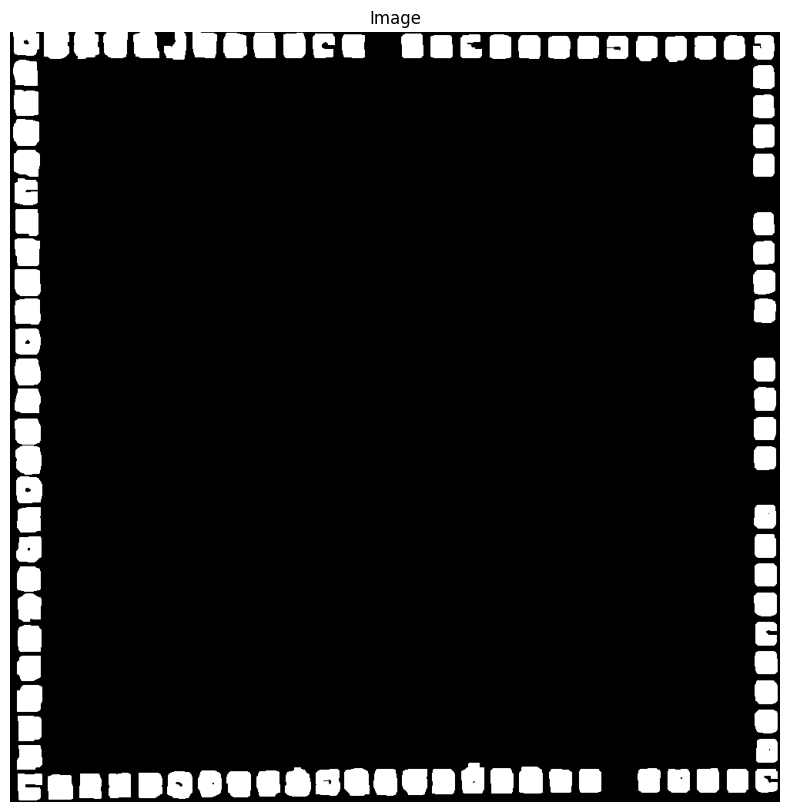

Detected Rails | X: 23, 980 | Y: 18, 973
Repaired 5 missing pads.
Stats -> Pad Size: 31.0 | Pitch (Pad+Gap): 38.0


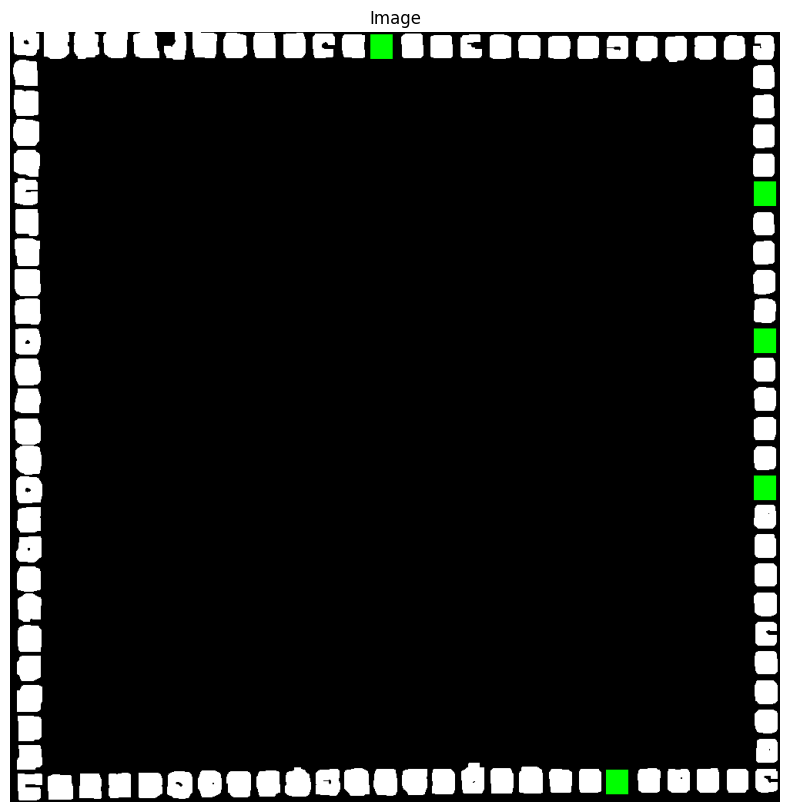

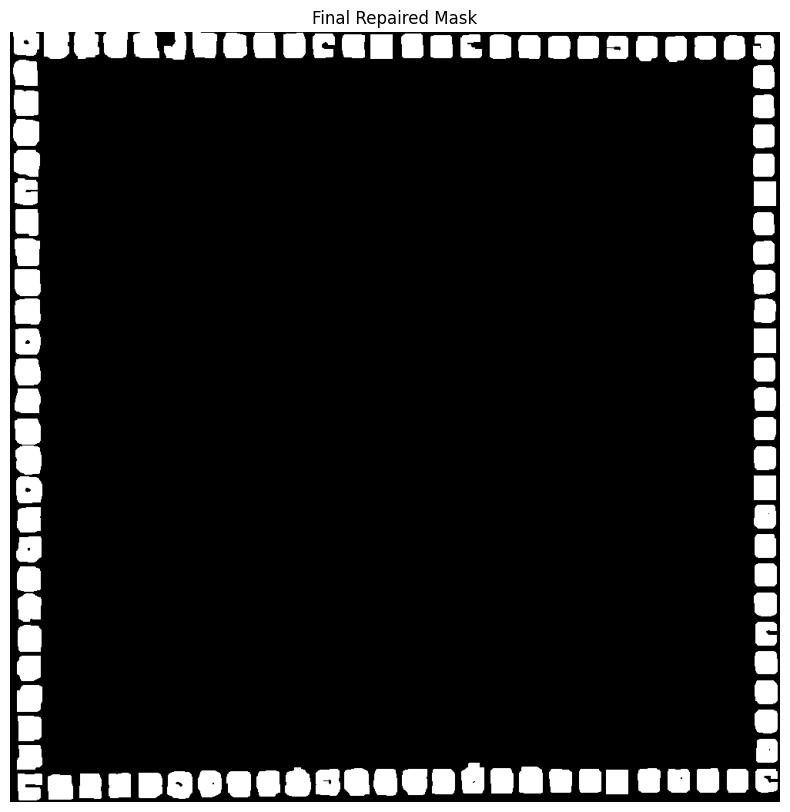

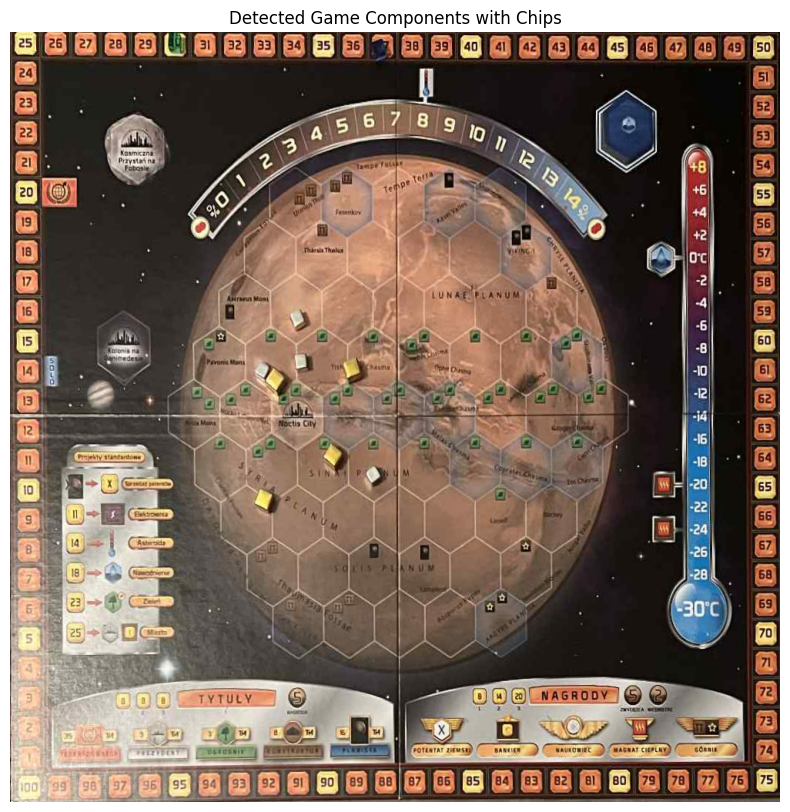

--- Top 3 Anomalies (Hue Weighted) ---
#1: Score 73.13 at (200, 0)
#2: Score 72.12 at (468, 3)
#3: Score 22.14 at (121, 0)


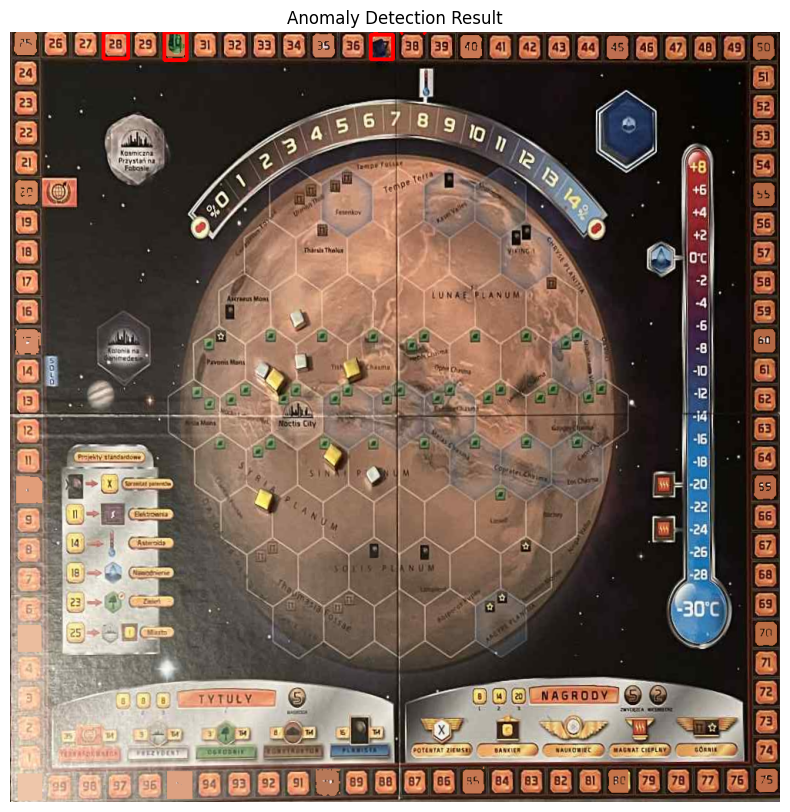

In [11]:
# 2. Normalize the board (Turn Yellows to Oranges)
res,map_conts,player_conts = detect_game_components(cv2.imread('maps/mapa21.jpg'))
debug_img = res.copy()
for pc in player_conts:
    cv2.drawContours(debug_img, [pc], -1, (0, 255, 0), 4)
cv2.drawContours(debug_img, [map_conts], -1, (255, 0, 0), 4)
track, warped = isolate_score_track(res, map_conts)
show_inline(warped, title="Isolated Score Track")
player_num = len(player_conts)

perfect_board = crop_floor_by_lab(track)
show_inline(perfect_board)
cleaned_mask = refine_mask(perfect_board)
show_inline(cleaned_mask)


final_mask, debug_view = repair_mask(cleaned_mask, total_pads=100)
final_mask = refine_mask(final_mask)
show_inline(debug_view)
show_inline(final_mask, title="Final Repaired Mask")
res,pads = process_chip_grid(warped, final_mask)
show_inline(res, title="Detected Game Components with Chips")
normalized_vis = normalize_board_colors_robust(res, pads)

# 3. Detect Anomalies using PERIOD=1
# We set period=1 so it compares every tile to its immediate neighbor (1 vs 2, 5 vs 6)
# This works now because #5 is painted orange!
result_img, anomalies = detect_anomalies_top_n(
    normalized_vis, 
    pads, 
    neighbor_count=2, # Compare to immediate left/right neighbors
    top_n=player_num+1
)

show_inline(result_img, title="Anomaly Detection Result")

In [12]:

def extract_inner_map(original_img, pad_data):
    
    if not pad_data:
        print("No pad data provided.")
        return original_img

    
    pad_tl = min(pad_data, key=lambda p: p['x'] + p['y'])
    pad_tr = max(pad_data, key=lambda p: p['x'] - p['y'])
    pad_br = max(pad_data, key=lambda p: p['x'] + p['y'])
    pad_bl = min(pad_data, key=lambda p: p['x'] - p['y'])

    src_tl = [pad_tl['x'] + pad_tl['w'], pad_tl['y'] + pad_tl['h']]
    
    src_tr = [pad_tr['x'], pad_tr['y'] + pad_tr['h']]
    
    src_br = [pad_br['x'], pad_br['y']]
    
    src_bl = [pad_bl['x'] + pad_bl['w'], pad_bl['y']]

    src_pts = np.float32([src_tl, src_tr, src_br, src_bl])

    width_top = np.linalg.norm(src_pts[1] - src_pts[0])
    width_btm = np.linalg.norm(src_pts[2] - src_pts[3])
    max_width = int(max(width_top, width_btm))

    height_lft = np.linalg.norm(src_pts[3] - src_pts[0])
    height_rgt = np.linalg.norm(src_pts[2] - src_pts[1])
    max_height = int(max(height_lft, height_rgt))

    dst_pts = np.float32([
        [0, 0],
        [max_width - 1, 0],
        [max_width - 1, max_height - 1],
        [0, max_height - 1]
    ])

    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped_map = cv2.warpPerspective(original_img, M, (max_width, max_height))

    debug_img = original_img.copy()
    cv2.polylines(debug_img, [np.int32(src_pts)], isClosed=True, color=(0, 255, 0), thickness=3)

    return warped_map, debug_img


In [13]:
def correct_orientation(image):
    h, w = image.shape[:2]
    
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    lower_purple = np.array([125, 50, 50])
    upper_purple = np.array([170, 255, 255])
    
    mask = cv2.inRange(hsv, lower_purple, upper_purple)
    
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        print("Warning: No purple region found. Returning original.")
        return image
        
    largest_cnt = max(contours, key=cv2.contourArea)
    
    M = cv2.moments(largest_cnt)
    if M["m00"] == 0: return image
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    
    rel_x = cX / w
    rel_y = cY / h
    
    
    if rel_y > 0.60:
        return image
    elif rel_y < 0.40:
        return cv2.rotate(image, cv2.ROTATE_180)
    elif rel_x < 0.40:
        return cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif rel_x > 0.60:
        return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

    return image

def four_point_transform(image, pts):
    rect = order_points(pts.reshape(4, 2))
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

def get_warped_player_boards(original_img, player_contours):
    warped_images = []
    if original_img is None or not player_contours:
        return warped_images

    for contour in player_contours:
        try:
            warped = four_point_transform(original_img, contour)
            
            oriented = correct_orientation(warped)
            
            warped_images.append(oriented)
        except Exception as e:
            print(f"Could not warp/rotate a contour: {e}")
            
    return warped_images


In [14]:
#save empty board for reference
# cv2.imwrite('ref_pb.jpg', player_board_images[0])


 (2, 18, 44,  1, 11, 32),   # Seg 1: Gold Res

( 6, 18, 44,11, 17, 32),  # Seg 2: Gold Prod

(18, 31, 44, 1, 11, 32),   # Seg 3: Iron Res

(18, 30, 44, 11, 16, 32),  # Seg 4: Iron Prod

(31, 43, 44, 1, 11, 32),   # Seg 5: Titan Res

( 30, 42, 44,11, 16, 32),  # Seg 6: Titan Prod

(2, 16, 44,  23, 31, 32),  # Seg 7: Flowers Res 

(2, 16, 44 ,18, 22, 32),  # Seg 8: Flowers Prod

(16, 28, 44, 23, 31, 32),  # Seg 9: Energy Res

( 16, 28, 44,18, 22, 32),  # Seg 10: Energy Prod

(29, 43, 44, 23, 31, 32),  # Seg 11: Heat Res

( 29, 42, 44,18, 23, 32),   # Seg 12: Heat Prod

In [15]:
def segment_player_board(images):
    def get_crop(spec,image):
        x_s, x_e, x_div,y_s, y_e, y_div = spec
        
        y1 = int((y_s / y_div) * h)
        y2 = int((y_e / y_div) * h)
        x1 = int((x_s / x_div) * w)
        x2 = int((x_e / x_div) * w)
        return image[y1:y2, x1:x2]

    specs = [
        (2, 18, 44,  1, 11, 32),   # Seg 1: Gold Res
        ( 6, 18, 44,11, 17, 32),  # Seg 2: Gold Prod
        
        (18, 31, 44, 1, 11, 32),   # Seg 3: Iron Res
        (18, 30, 44, 11, 16, 32),  # Seg 4: Iron Prod
        
        (31, 43, 44, 1, 11, 32),   # Seg 5: Titan Res
        ( 30, 42, 44,11, 16, 32),  # Seg 6: Titan Prod
        
        (2, 16, 44,  23, 31, 32),  # Seg 7: Flowers Res (Plants)
        (2, 16, 44 ,18, 22, 32),  # Seg 8: Flowers Prod
        
        (16, 28, 44, 23, 31, 32),  # Seg 9: Energy Res
        ( 16, 28, 44,18, 22, 32),  # Seg 10: Energy Prod
        
        (29, 43, 44, 23, 31, 32),  # Seg 11: Heat Res
        ( 29, 42, 44,18, 23, 32),   # Seg 12: Heat Prod
    ]  

    result_dict ={}
    for idx, image in enumerate(images):
        h, w = image.shape[:2]

        segments=[]
        for spec in specs:
            segments.append(get_crop(spec, image))

        cur_dict = {
            "img": image,
            "resources": {
                "gold":    segments[0], 
                "iron":    segments[2],  
                "titan":   segments[4], 
                "flowers": segments[6], 
                "energy":  segments[8],  
                "heat":    segments[10]  
            },
            "production": {
                "gold":    segments[1],  
                "iron":    segments[3],  
                "titan":   segments[5],  
                "flowers": segments[7],  
                "energy":  segments[9],  
                "heat":    segments[11]  
            }
        }
        result_dict[idx] = cur_dict
    image = ref_board
    h, w = image.shape[:2]
    segments=[]
    for spec in specs:
        segments.append(get_crop(spec, image))
    cur_dict = {
            "img": image,
            "resources": {
                "gold":    segments[0],  # seg1
                "iron":    segments[2],  # seg3
                "titan":   segments[4],  # seg5
                "flowers": segments[6],  # seg7
                "energy":  segments[8],  # seg9
                "heat":    segments[10]  # seg11
            },
            "production": {
                "gold":    segments[1],  # seg2
                "iron":    segments[3],  # seg4
                "titan":   segments[5],  # seg6
                "flowers": segments[7],  # seg8
                "energy":  segments[9],  # seg10
                "heat":    segments[11]  # seg12
            }
        }
    result_dict[-1] = cur_dict
    return result_dict


In [16]:


def find_grid_by_big_contour(img,is_gold):
    if img is None: return
    
    debug_img = img.copy()

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(lab, (3, 3), 0)

    closed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8))
    target_percentile = 45
    
    dynamic_thresh_val = np.percentile(closed, target_percentile)
    
    
    thresh = cv2.threshold(closed, dynamic_thresh_val, 255, cv2.THRESH_BINARY)[1]
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print("No contours found.")
        return

    big_contour = max(contours, key=cv2.contourArea)
    bx, by, bw, bh = cv2.boundingRect(big_contour)
    cv2.rectangle(debug_img, (bx, by), (bx+bw, by+bh), (255, 0, 0), 2)
    
    if not is_gold:
        num_units_wide = 6 
        unit_width_float = bw / num_units_wide 
        unit_height = bh // 2 

        final_squares = []

        for i in range(num_units_wide):
            x = bx + round(i * unit_width_float)
            x_end = bx + round((i + 1) * unit_width_float)
            w = x_end - x 
            y = by 
            h = unit_height
            final_squares.append((x, y, w, h))

        for i in range(1, 6): 
            x = bx + round(i * unit_width_float)
            x_end = bx + round((i + 1) * unit_width_float)
            w = x_end - x
            y = by + unit_height 
            h = unit_height
            final_squares.append((x, y, w, h))
    else:
        sq_w = bw // 6
        sq_h = bh // 3
        
        final_squares = []
        
        for i in range(5):
            x = bx + int(sq_w*1.1) + (i * sq_w)
            y = by 
            final_squares.append((x, y, sq_w, sq_h))

        for i in range(6):
            x = bx + int(sq_w*0.1)+ (i * sq_w)
            y = by + int(sq_h*1.1)
            final_squares.append((x, y, sq_w, sq_h))

        for i in range(5):
            x = bx + int(sq_w*1.1) + (i * sq_w)
            y = by + int(sq_h*2.2)
            final_squares.append((x, y, sq_w, sq_h))
    for i, (sx, sy, sw, sh) in enumerate(final_squares):
        cv2.rectangle(debug_img, (sx, sy), (sx+sw, sy+sh), (0, 255, 0), 2)
    contour_coords = (bx, by, bw, bh)
    return final_squares,contour_coords




In [17]:

def project_box_by_scaling(ref_img, target_img, ref_box,ref_squares):
    debug_img = target_img.copy()
    h_ref, w_ref = ref_img.shape[:2]
    h_tgt, w_tgt = target_img.shape[:2]

    if h_ref == 0 or w_ref == 0:
        raise ValueError("Reference image has 0 dimension.")

    sx = w_tgt / w_ref
    sy = h_tgt / h_ref

    bx, by, bw, bh = ref_box

    new_bx = int(bx * sx)
    new_by = int(by * sy)
    new_bw = int(bw * sx)
    new_bh = int(bh * sy)
    cv2.rectangle(debug_img, (new_bx, new_by), (new_bx+new_bw, new_by+new_bh), (255, 0, 0), 2)
    new_squares = []
    for (sx_ref, sy_ref, sw_ref, sh_ref) in ref_squares:
        nsx = int(sx_ref * sx)
        nsy = int(sy_ref * sy)
        nsw = int(sw_ref * sx)
        nsh = int(sh_ref * sy)
        new_squares.append((nsx, nsy, nsw, nsh))
    return (new_bx, new_by, new_bw, new_bh),new_squares, (sx, sy)




In [18]:
def detect_color_outlier(img, squares):
    means_lab = []
    
    for i, (x, y, w, h) in enumerate(squares):
        roi = img[y:y+h, x:x+w]
        
        margin_x = int(w * 0)
        margin_y = int(h * 0)
        
        if roi.shape[0] <= 2*margin_y or roi.shape[1] <= 2*margin_x:
            center_roi = roi 
        else:
            center_roi = roi[margin_y:h-margin_y, margin_x:w-margin_x]

        avg_lab = cv2.mean(center_roi)
        means_lab.append(avg_lab)

    means_np = np.array(means_lab)
    median_color = np.median(means_np, axis=0)
    distances = np.linalg.norm(means_np - median_color, axis=1)
    
    outlier_idx = np.argmax(distances)
    max_dist = distances[outlier_idx]

    x, y, w, h = squares[outlier_idx]
    
    cube_roi = img[y:y+h, x:x+w].copy()
    
    h_roi, w_roi = cube_roi.shape[:2]
    my = int(h_roi * 0.3)
    mx = int(w_roi * 0.3)
    center_crop_bgr = cube_roi[my:h_roi-my, mx:w_roi-mx]
    mean_bgr = cv2.mean(center_crop_bgr)[:3]
    mean_bgr = tuple(map(int, mean_bgr)) 

    return outlier_idx, max_dist, mean_bgr

In [19]:
def get_production_levels(player_id,segmented_board,ref_contours):
    production_levels = {}
    colors=[]
    
    for resource, prod_img in segmented_board[player_id]['production'].items():
        ref_img = ref_contours[resource][0]      
        ref_box = ref_contours[resource][1] 

        target_img = segmented_board[player_id]['production'][resource] 
        contours,squares,_ = project_box_by_scaling(ref_img, target_img, ref_box, ref_contours[resource][2])
        outlier_index, confidence,color = detect_color_outlier(target_img, squares)
        colors.append(color)

        print(f"The odd square is at Index: {outlier_index} (Distance: {confidence:.2f})")

        debug_img_color = target_img.copy()

        ox, oy, ow, oh = squares[outlier_index]

        cv2.rectangle(debug_img_color, (ox, oy), (ox+ow, oy+oh), (0, 255, 255), 4)
        cv2.putText(debug_img_color, "ODD ONE", (ox, oy - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
        if resource == 'gold':
            outlier_index = outlier_index -5
        production_levels[resource] = outlier_index
    bgr_np = np.array(colors)
    median_color_float = np.median(bgr_np, axis=0)
    median_color = tuple(map(int, median_color_float))
    return production_levels, median_color

In [20]:
def visualize_player_color(color_bgr, size=(200, 200)):
    """
    Creates a solid color square to visualize the detected player color.
    """
    # 1. Create a blank black image (Height, Width, Channels)
    # np.uint8 is crucial for OpenCV images
    swatch = np.zeros((size[1], size[0], 3), dtype=np.uint8)
    
    # 2. Fill the image with the color
    # Numpy allows us to assign a tuple (B, G, R) to all pixels at once
    swatch[:] = color_bgr
    
    # 3. Add text for readability (Optional)
    # Calculate brightness to decide if text should be black or white
    # (Standard formula: 0.299*R + 0.587*G + 0.114*B)
    b, g, r = color_bgr
    brightness = (r * 0.299 + g * 0.587 + b * 0.114)
    text_color = (0, 0, 0) if brightness > 127 else (255, 255, 255)
    
    cv2.putText(swatch, "Median Color", (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, text_color, 2)
    cv2.putText(swatch, str(color_bgr), (10, 60), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 1)

    return swatch


In [21]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def filter_anomalies_by_pixel_match(original_img, anomalies, target_color_bgr, top_percent=0.2, debug=False):
    target_pixel = np.uint8([[target_color_bgr]])
    target_hsv = cv2.cvtColor(target_pixel, cv2.COLOR_BGR2HSV)[0][0]
    t_h, t_s, t_v = target_hsv.astype(float)

    scored_candidates = []

    for p in anomalies:
        x, y, w, h = p['x'], p['y'], p['w'], p['h']
        roi = original_img[y:y+h, x:x+w]
        if roi.size == 0: continue

        roi_hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV).astype(float)
        h_map, s_map, v_map = roi_hsv[:,:,0], roi_hsv[:,:,1], roi_hsv[:,:,2]

        # Hue distance with 180-degree wrap-around
        diff_h = np.abs(h_map - t_h)
        diff_h = np.minimum(diff_h, 180 - diff_h)
        
        diff_s = np.abs(s_map - t_s)
        diff_v = np.abs(v_map - t_v)

        # Distance Map: How far each pixel is from target
        # Give Hue 3x importance, and ignore brightness (Value) differences
        dist_map = np.sqrt((diff_h * 3.0)**2 + (diff_s)**2 + (diff_v * 0.1)**2)

        flat_dists = dist_map.flatten()
        num_pixels = len(flat_dists)
        num_top = max(1, int(num_pixels * top_percent))
        
        top_k_dists = np.partition(flat_dists, num_top)[:num_top]
        match_score = np.mean(top_k_dists)

        # --- DEBUG VISUALIZATION ---
        if debug:
            show_inline(visualize_player_color(target_color_bgr, size=(100, 100)))
            threshold_val = np.max(top_k_dists) # The "worst" of the best pixels
            best_pixels_mask = (dist_map <= threshold_val).astype(np.uint8) * 255
            
            fig, ax = plt.subplots(1, 3, figsize=(12, 4))
            ax[0].imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
            ax[0].set_title(f"Original ROI (ID: {p.get('id')})")
            
            # Heatmap (Cooler = Closer Match)
            im = ax[1].imshow(dist_map, cmap='viridis')
            ax[1].set_title("Distance Map (Heatmap)")
            plt.colorbar(im, ax=ax[1])
            
            # Binary Mask of what the score is based on
            ax[2].imshow(best_pixels_mask, cmap='gray')
            ax[2].set_title(f"Top {top_percent*100}% Pixels Used")
            
            plt.tight_layout()
            plt.show()
        # ---------------------------

        scored_candidates.append({
            'pad': p,
            'distance': match_score, 
            'original_score': p.get('deviation', 0)
        })
    print(scored_candidates)
    scored_candidates.sort(key=lambda x: x['distance'])
    return scored_candidates[0]['pad'].get('id', -1) if scored_candidates else -1

In [22]:
def get_crop(spec,image):
        w,h = image.shape[1],image.shape[0]
        x_s, x_e, x_div,y_s, y_e, y_div = spec
        y1 = int((y_s / y_div) * h)
        y2 = int((y_e / y_div) * h)
        x1 = int((x_s / x_div) * w)
        x2 = int((x_e / x_div) * w)
        return image[y1:y2, x1:x2]

In [23]:
def get_ref_ocean(inner_map):
    spec = ( 35, 47, 48, 0, 8, 40)
    ocean_ref = get_crop(spec,inner_map)
    return ocean_ref

In [24]:
def clear_borders(img, border_size=15):
    """
    Sets the outer 'border_size' pixels of the image to black.
    Useful for removing edge artifacts from warping.
    """
    h, w = img.shape[:2]
    img[:border_size, :] = 0        # Top
    img[h-border_size:, :] = 0      # Bottom
    img[:, :border_size] = 0        # Left
    img[:, w-border_size:] = 0      # Right
    return img

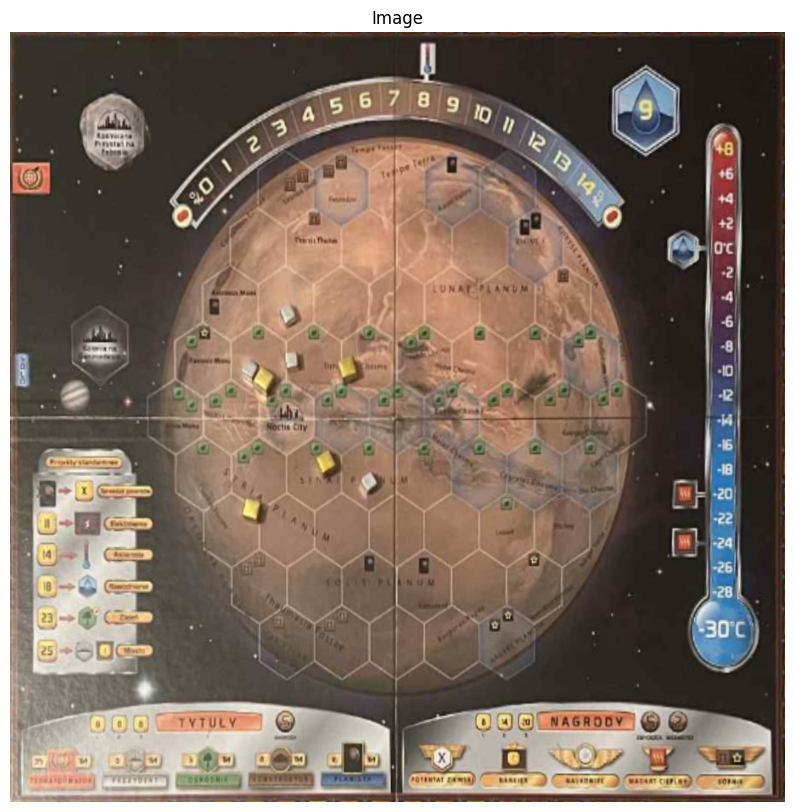

True

In [25]:
i_map = cv2.imread('help/ex_inner_map.png')
show_inline(i_map)
ocean_ref = get_ref_ocean(i_map)
cv2.imwrite('help/ref_ocean.png', ocean_ref)

In [26]:


def fill_mask_holes(mask):
    """
    Fills holes in a binary mask or grayscale image.
    
    Args:
        mask (numpy.ndarray): Input image (grayscale or binary).
        
    Returns:
        numpy.ndarray: The mask with holes filled.
    """
    # Ensure the mask is binary (0 and 255)
    # If your input is the Hue channel directly, you might need to threshold it first
    # This line ensures we have a clean binary image to work with
    _, binary_mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy to draw on
    filled_mask = binary_mask.copy()

    # Draw all external contours filled with white (255)
    # -1 means draw all contours
    # thickness=cv2.FILLED fills the interior
    cv2.drawContours(filled_mask, contours, -1, 255, thickness=cv2.FILLED)

    return filled_mask

def check_yellow_presence(hsv_img, tile_mask=None, threshold_ratio=0.02):
    """
    Checks if the image contains significant yellow color.
    
    Args:
        hsv_img: The ORIGINAL image in HSV format (not the blue-filtered one!).
        tile_mask: (Optional) The binary mask of the tile shape (from keep_only_larges_contour).
                   This ensures we don't accidentally count yellow noise in the background.
        threshold_ratio: The percentage of the tile that must be yellow to return True (e.g., 0.02 = 2%).

    Returns:
        bool: True if yellow is detected.
        float: The ratio of yellow pixels found.
    """
    # 1. Define Yellow Range
    # OpenCV Hue is 0-179. Yellow is typically ~30.
    # We use a range of 20-40 to capture most yellow/golden tones.
    lower_yellow = np.array([15, 50, 50])  # Slightly lower to catch orange-yellows
    upper_yellow = np.array([40, 255, 255])
    # 2. Create the Yellow Mask
    yellow_mask = cv2.inRange(hsv_img, lower_yellow, upper_yellow)

    # 3. Restrict search to the tile area only (if mask provided)
    if tile_mask is not None:
        yellow_mask = cv2.bitwise_and(yellow_mask, yellow_mask, mask=tile_mask)
        total_area = cv2.countNonZero(tile_mask)
    else:
        # If no mask, assume the whole image is valid area
        total_area = hsv_img.shape[0] * hsv_img.shape[1]

    # 4. Count Yellow Pixels
    yellow_pixels = cv2.countNonZero(yellow_mask)
    print(yellow_pixels)
    return yellow_pixels < 10
def filter_blue_only(img):
        # Hue: 90-130 covers most blues
        # Saturation: 50-255 ignores greyish/white noise
        # Value: 50-255 ignores very dark/black areas
        lower_blue = np.array([20, 0, 50])
        upper_blue = np.array([135, 255, 255])

        # 3. Create the mask
        blue_mask = cv2.inRange(img, lower_blue, upper_blue)

        # 4. Clean up the mask (remove small noise)
        kernel = np.ones((5,5), np.uint8)
        blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_OPEN, kernel)
        blue_mask = fill_mask_holes(blue_mask)
        # 5. Apply mask to the original image
        blue_only_img = cv2.bitwise_and(img, img, mask=blue_mask)
        return blue_only_img,blue_mask
def keep_only_larges_contour(img):
        h, s, v = cv2.split(img)
        _, thresh = cv2.threshold(v, 1, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return img
        largest_contour = max(contours, key=cv2.contourArea)
        mask = np.zeros_like(v)
        cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
        result = cv2.bitwise_and(img, img, mask=mask)
        return result,mask


def has_oceans(candidate):
    candidate_hsv = cv2.cvtColor(candidate, cv2.COLOR_BGR2HSV)
    candidate_hsv,_ = filter_blue_only(candidate_hsv)
    candidate_hsv,blue_mask_candidate = keep_only_larges_contour(candidate_hsv)
    return check_yellow_presence(candidate_hsv, tile_mask=blue_mask_candidate)
    

    


In [27]:

def analyze_frame(img):
    map_info = {}
    img_res, map_cnt, player_cnts = detect_game_components(img)
    #show map contours on original
    debug_img = img_res.copy()
    for pc in player_cnts:
        cv2.drawContours(debug_img, [pc], -1, (0, 255, 0), 4)
    cv2.drawContours(debug_img, [map_cnt], -1, (255, 0, 0), 4)
    player_num = len(player_cnts)

    score_track_img, map_flat = isolate_score_track(img_res, map_cnt)
    perfect_board = crop_floor_by_lab(score_track_img)
    perfect_board = clear_borders(perfect_board, border_size=5)
    cleaned_mask = refine_mask(perfect_board)
    final_mask, debug_view = repair_mask(cleaned_mask, total_pads=100)
    result_img, pad_data = process_chip_grid(score_track_img, final_mask)
    normalized_result_img = normalize_board_colors_robust(result_img, pad_data)

    # cv2.imwrite('final_corrected_sort.png', result_img)
    for i, pad in enumerate(pad_data):
        pad['id'] = (i+125)%100
        if pad['id'] == 0:
            pad['id'] = 100
    
    result_img, best_guesses = detect_anomalies_top_n(normalized_result_img, pad_data, top_n=player_num+3)
    final_map, crop_debug = extract_inner_map(map_flat, pad_data)
    # cv2.imwrite('final_inner_map.png', final_map)
    map_info['end_condition_ocean'] = has_oceans(get_ref_ocean(final_map))
    print(f"has_ocean: {map_info['end_condition_ocean']}")

    player_board_images = get_warped_player_boards(img_res, player_cnts)


    segmented_boards = segment_player_board(player_board_images)
    ref_contours = {}
    for resource in segmented_boards[-1]['production'].items():
        res_name, res_img = resource
        if res_name == 'gold':
            squares,big_contour_coords = find_grid_by_big_contour(res_img, is_gold=True)
        else:  
            squares,big_contour_coords = find_grid_by_big_contour(res_img, is_gold=False)
        ref_contours[res_name] = res_img,big_contour_coords,squares

    player_info = {id: {} for id in range(player_num)}
    for pid in range(player_num):
        prod_levels, color = get_production_levels(pid, segmented_boards, ref_contours)
        player_info[pid]['production_levels'] = prod_levels
        player_info[pid]['color'] = color
        color_swatch_img = visualize_player_color(color)
        player_info[pid]['score'] = filter_anomalies_by_pixel_match(map_flat, best_guesses, player_info[pid]['color'])

    return img_res,player_cnts,map_cnt,player_info,map_info


Board detected (Contour #0) using Extreme Points!
Auto-Rotation applied: 90 degrees (Score: 3996)
Stats -> Pad Size: 32.0 | Pitch (Pad+Gap): 38.0
Detected Rails | X: 28, 975 | Y: 25, 977
Repaired 1 missing pads.
--- Top 5 Anomalies (Hue Weighted) ---
#1: Score 47.94 at (620, 10)
#2: Score 23.81 at (586, 8)
#3: Score 22.26 at (549, 8)
#4: Score 22.03 at (962, 245)
#5: Score 18.11 at (699, 11)
432
has_ocean: False
The odd square is at Index: 10 (Distance: 112.11)
The odd square is at Index: 8 (Distance: 95.64)
The odd square is at Index: 1 (Distance: 82.99)
The odd square is at Index: 8 (Distance: 36.26)
The odd square is at Index: 3 (Distance: 59.56)
The odd square is at Index: 1 (Distance: 45.82)
[{'pad': {'x': 620, 'y': 10, 'w': 29, 'h': 32, 'cx': 634, 'cy': 26, 'real': True, 'angle': -1.3028522198644907, 'id': 41, 'hsv': array([ 15, 171, 143], dtype=uint8), 'deviation': 47.94209470230149}, 'distance': 32.01539053265403, 'original_score': 47.94209470230149}, {'pad': {'x': 586, 'y': 8,

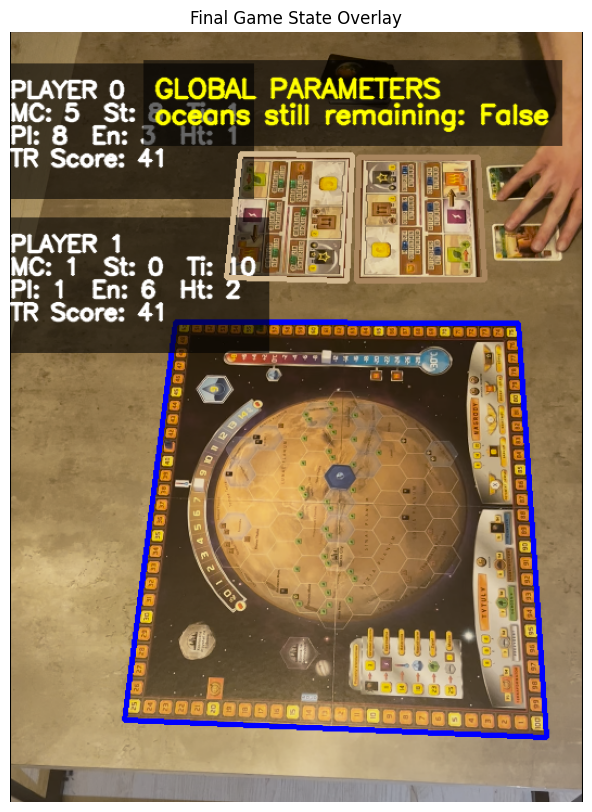

In [28]:


def draw_multiline_text(img, text_lines, position, font_scale=0.6, color=(255, 255, 255), thickness=1):
    """Helper to draw multiple lines of text with a background box."""
    font = cv2.FONT_HERSHEY_SIMPLEX
    y_offset = position[1]
    x = position[0]
    
    # 1. Calculate the total size of the text box
    max_w = 0
    total_h = 0
    line_height = int(30 * font_scale)
    
    for line in text_lines:
        (w, h), _ = cv2.getTextSize(line, font, font_scale, thickness)
        max_w = max(max_w, w)
        total_h += line_height + 5

    # 2. Draw Semi-Transparent Background
    # Add some padding
    pad = 10
    bg_rect = (x - pad, y_offset - line_height - pad, x + max_w + pad, y_offset + total_h - line_height + pad)
    
    overlay = img.copy()
    cv2.rectangle(overlay, (bg_rect[0], bg_rect[1]), (bg_rect[2], bg_rect[3]), (0, 0, 0), -1)
    
    # Blend it (Opacity 0.6)
    alpha = 0.6
    cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, img)

    # 3. Draw Text
    curr_y = y_offset
    for line in text_lines:
        cv2.putText(img, line, (x, curr_y), font, font_scale, color, thickness, cv2.LINE_AA)
        curr_y += line_height

def overlay_stats(main_map_image, player_contours,map_conts, player_info_dict, map_info):
    """
    Overlays player stats AND global map info on the image.
    """
    final_vis = main_map_image.copy()
    img_h, img_w = final_vis.shape[:2]
    if map_conts is not None:
        cv2.drawContours(final_vis, [map_conts], -1, (255, 0, 0), 3)
    # --- 1. Draw Player Boards Stats ---
    for player_id, stats in player_info_dict.items():
        if player_id >= len(player_contours):
            continue

        cnt = player_contours[player_id]
        x, y, w, h = cv2.boundingRect(cnt)
        text_pos = (x + 220, y) 

        lines = [f"PLAYER {player_id}"]
        if 'production_levels' in stats:
            prod = stats['production_levels']
            lines.append(f"MC: {prod.get('gold', 0)}  St: {prod.get('iron', 0)}  Ti: {prod.get('titan', 0)}")
            lines.append(f"Pl: {prod.get('flowers', 0)}  En: {prod.get('energy', 0)}  Ht: {prod.get('heat', 0)}")
        
        if 'score' in stats:
             lines.append(f"TR Score: {stats['score']}")

        color_bgr = stats.get('color', (0, 0, 255))
        draw_multiline_text(final_vis, lines, (0,60+final_vis.shape[0]*player_id//5), font_scale=0.7, thickness=2)
        cv2.drawContours(final_vis, [cnt], -1, color_bgr, 3)

    # --- 2. Draw Global Map Info (Top Right) ---
    if map_info:
        map_lines = ["GLOBAL PARAMETERS"]
        
        # Check for your specific ocean condition key
        ocean_end = map_info.get('end_condition_ocean', 0)
        map_lines.append(f"oceans still remaining: {ocean_end}")
        
        # Add other map_info keys dynamically if they exist later (Temp/Oxygen)
        for key, val in map_info.items():
            if key != 'end_condition_ocean':
                map_lines.append(f"{key.capitalize()}: {val}")

        # Calculate position for Top-Right
        # We find the width of the box to right-align it
        font = cv2.FONT_HERSHEY_SIMPLEX
        scale = 0.8
        thick = 2
        max_line_w = max([cv2.getTextSize(line, font, scale, thick)[0][0] for line in map_lines])
        
        # Position: Right edge minus width minus padding
        map_text_pos = (img_w - max_line_w - 30, 60) 
        
        draw_multiline_text(final_vis, map_lines, map_text_pos, 
                            font_scale=scale, color=(0, 255, 255), thickness=thick)
    return final_vis
# ==========================================
# Usage Example
# ==========================================

# Assuming:
# 'img_res' is your main detected image
# 'player_cnts' is the list of contours from detect_game_components
# 'player_info' is your dictionary of results: 
#      {0: {'production': {'gold':5, ...}, 'median_color': (255,0,0)}, 1: ...}
img = cv2.imread('maps/mapa26.jpg')
img_res, player_cnts,map_conts, player_info,map_info = analyze_frame(img)
print(player_info)
final_output = overlay_stats(img_res, player_cnts,map_conts, player_info,map_info)

show_inline(final_output, "Final Game State Overlay")

In [29]:
def draw_obstruction_debug(img, manager):
    """
    Draws obstruction status AND Centroid Tracking positions.
    """
    overlay = img.copy()
    
    # --- 1. Draw Contours & Status (Existing) ---
    # Visualize Players
    for pid, cnt in manager.stable_player_cnts.items():
        roi_id = f"p_{pid}"
        status = manager.obstruction_status.get(roi_id, "UNKNOWN")
        _draw_roi_debug(overlay, cnt, status, roi_id, manager)

    # Visualize Map (and quadrants)
    if manager.stable_map_cnt is not None:
        map_status = manager.obstruction_status.get("map", "UNKNOWN")
        _draw_roi_debug(overlay, manager.stable_map_cnt, map_status, "MAP", manager)
        
        quads = manager._split_contour(manager.stable_map_cnt)
        for k, q_cnt in quads.items():
            q_id = f"map{k}"
            if q_id in manager.debug_scores:
                 _draw_roi_debug(overlay, q_cnt, "Quad", q_id, manager, small=True)

    # --- 2. NEW: Draw Centroid Tracking Points ---
    # This shows exactly where the "Anchor" for each player is located
    for pid, center in manager.player_centroids.items():
        if center:
            cx, cy = center
            # Draw Red Crosshair
            cv2.line(overlay, (cx - 15, cy), (cx + 15, cy), (0, 0, 255), 2)
            cv2.line(overlay, (cx, cy - 15), (cx, cy + 15), (0, 0, 255), 2)
            
            # Draw Text Label (ID and Coordinates)
            label = f"ID:{pid} ({cx},{cy})"
            # Yellow text with black border for readability
            cv2.putText(overlay, label, (cx + 10, cy - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 3)
            cv2.putText(overlay, label, (cx + 10, cy - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

    return overlay

# Helper remains the same, included for completeness
def _draw_roi_debug(img, cnt, status, label_id, manager, small=False):
    color = (0, 255, 0) # Green
    
    if status == "BLOCKED": color = (0, 0, 255) # Red
    elif status == "BAD_SHAPE": color = (255, 0, 255) # Magenta
    elif status == "MISSING": color = (0, 255, 255) # Yellow
    
    cv2.drawContours(img, [cnt], -1, color, 2)
    
    scores = ""
    if label_id in manager.debug_scores:
        h, e = manager.debug_scores[label_id]
        scores = f" H:{h:.2f} E:{e:.2f}"
    
    if not small:
        x, y, w, h = cv2.boundingRect(cnt)
        text = f"{label_id}: {status}{scores}"
        cv2.rectangle(img, (x, y-25), (x+len(text)*10, y), color, -1)
        cv2.putText(img, text, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1)

In [30]:
from collections import deque, Counter
import cv2
import numpy as np

class GameStateManager:
    def __init__(self, history_len=120):
        self.history_len = history_len
        
        # History Deques
        self.player_history = deque(maxlen=history_len)
        self.map_history = deque(maxlen=history_len)
        
        # Last Known Good States (The "Frozen" values)
        self.stable_player_cnts = {} # Dict {0: cnt, 1: cnt}
        self.stable_map_cnt = None
        self.stable_player_info = {} # Dict {0: stats, 1: stats}
        self.stable_map_info = {}
        
        # Obstruction Memory
        self.ref_hists = {}    
        self.ref_edges = {}
        self.ref_areas = {}    # NEW: Remember valid contour areas
        self.blocked_timers = {} 
        
        # Status Flags (Per ROI)
        self.obstruction_status = {} # {'p_0': False, 'map': True, ...}
        self.debug_scores = {} 
        
        # Config
        self.MAX_BLOCKED_FRAMES = 60
        self.AREA_TOLERANCE = 0.05 # 5% area change allowed before flagging "Bad Contour"
        self.ASPECT_RATIO_TOL = 0.03
        self.HIST_THRESH = 0.65
        self.EDGE_THRESH = 0.70 
        self.ALPHA = 0.05
        # === NEW: TRACKING MEMORY ===
        # Stores {pid: (x, y)}
        self.player_centroids = {} 
        # Max distance a board can "jump" between frames (pixels)
        self.TRACKING_THRESH = 200
    def _get_centroid(self, cnt):
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            return (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
        return None
    def _order_points(self, pts):
            # Initialize a list of coordinates that will be ordered
            rect = np.zeros((4, 2), dtype="float32")
            
            # The top-left point will have the smallest sum, whereas
            # the bottom-right point will have the largest sum
            s = pts.sum(axis=1)
            rect[0] = pts[np.argmin(s)] # TL
            rect[2] = pts[np.argmax(s)] # BR
            
            # Now, compute the difference between the points, the
            # top-right point will have the smallest difference,
            # whereas the bottom-left will have the largest difference
            diff = np.diff(pts, axis=1)
            rect[1] = pts[np.argmin(diff)] # TR
            rect[3] = pts[np.argmax(diff)] # BL
            
            return rect
    # --- HELPER: Geometry Check (Area) ---
    def _check_geometry(self, roi_id, contour):
        """Returns True if Area AND Shape are stable."""
        area = cv2.contourArea(contour)
        if area == 0: return False
        
        # Calculate Aspect Ratio (Width / Height)
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)

        # 1. Learn Reference if missing
        if roi_id not in self.ref_areas:
            self.ref_areas[roi_id] = {'area': area, 'ar': aspect_ratio}
            return True

        ref = self.ref_areas[roi_id]
        
        # 2. Check Area (The "Size" Check)
        area_diff = abs(area - ref['area']) / ref['area']
        
        # 3. Check Aspect Ratio (The "Shape" Check)
        ar_diff = abs(aspect_ratio - ref['ar']) / ref['ar']
        
        # If EITHER deviates too much, it's a BAD SHAPE.
        if area_diff > self.AREA_TOLERANCE or ar_diff > self.ASPECT_RATIO_TOL:
            # print(f"DEBUG: {roi_id} Bad Shape! AreaDiff:{area_diff:.3f} ARDiff:{ar_diff:.3f}")
            return False 

        # Slowly update reference
        self.ref_areas[roi_id]['area'] = (ref['area'] * (1 - self.ALPHA)) + (area * self.ALPHA)
        self.ref_areas[roi_id]['ar']   = (ref['ar'] * (1 - self.ALPHA)) + (aspect_ratio * self.ALPHA)
        
        return True

    # --- HELPER: Edge Density ---
    def _get_edge_density(self, frame, contour, is_map=False):
        x, y, w, h = cv2.boundingRect(contour)
        if w <= 0 or h <= 0: return 0
        roi = frame[y:y+h, x:x+w]
        rh, rw = roi.shape[:2]
        if rh == 0 or rw == 0: return 0
        
        mask = np.zeros((rh, rw), dtype=np.uint8)
        roi_cnt = contour - [x, y]
        cv2.drawContours(mask, [roi_cnt], -1, 255, -1)

        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        t1, t2 = (30, 100) if is_map else (50, 150)
        edges = cv2.Canny(gray, t1, t2) 
        masked_edges = cv2.bitwise_and(edges, edges, mask=mask)
        total = cv2.countNonZero(mask)
        return (cv2.countNonZero(masked_edges) / total) if total > 0 else 0

    # --- HELPER: Color Hist ---
    def _get_hist(self, frame, contour):
        mask = np.zeros(frame.shape[:2], dtype=np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, -1)
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([hsv], [0, 1], mask, [180, 255], [0, 180, 0, 256])
        cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)
        return hist

    # --- CORE: Check Everything ---
    def _check_status(self, frame, roi_id, contour, is_map=False):
        """Returns 'OK', 'BLOCKED', or 'BAD_SHAPE'"""
        
        # 1. GEOMETRY CHECK (Fastest fail)
        if not self._check_geometry(roi_id, contour):
            return "BAD_SHAPE"

        # 2. OBSTRUCTION CHECK (Color + Texture)
        curr_hist = self._get_hist(frame, contour)
        curr_edges = self._get_edge_density(frame, contour, is_map)
        
        if roi_id not in self.ref_hists:
            self.ref_hists[roi_id] = curr_hist
            self.ref_edges[roi_id] = curr_edges
            self.debug_scores[roi_id] = (1.0, 1.0)
            return "OK"
            
        hist_score = cv2.compareHist(self.ref_hists[roi_id], curr_hist, cv2.HISTCMP_CORREL)
        ref_e = self.ref_edges[roi_id] + 1e-6
        edge_ratio = curr_edges / ref_e
        self.debug_scores[roi_id] = (hist_score, edge_ratio)

        is_color_bad = hist_score < self.HIST_THRESH
        is_texture_gone = edge_ratio < self.EDGE_THRESH

        status = "OK"
        if is_color_bad:
            if is_texture_gone:
                status = "BLOCKED"
            else:
                # Shadow -> Update references slowly
                cv2.accumulateWeighted(curr_hist, self.ref_hists[roi_id], self.ALPHA)
        else:
            # Clear -> Update references
            cv2.accumulateWeighted(curr_hist, self.ref_hists[roi_id], self.ALPHA)
            self.ref_edges[roi_id] = (self.ref_edges[roi_id] * (1-self.ALPHA)) + (curr_edges * self.ALPHA)
            
        return status

    def update(self, frame, player_cnts, map_cnt, player_info, map_info):
            # ==================================================
            # 1. PLAYER ID TRACKING (Centroid Matching)
            # ==================================================
            current_cnts_dict = {}
            current_info_dict = {} 
            
            # A. FIRST RUN INITIALIZATION
            if not self.player_centroids and player_cnts:
                # Sort Left-to-Right
                sorted_cnts = sorted(player_cnts, key=lambda c: cv2.boundingRect(c)[0])
                for i, cnt in enumerate(sorted_cnts):
                    if i > 1: break 
                    cent = self._get_centroid(cnt)
                    if cent:
                        self.player_centroids[i] = cent
                        current_cnts_dict[i] = cnt
                        if player_info and i in player_info:
                            current_info_dict[i] = player_info[i]

            # B. TRACKING UPDATE (Subsequent Frames)
            elif player_cnts:
                used_contours = set()
                
                for pid, known_cent in self.player_centroids.items():
                    best_dist = self.TRACKING_THRESH
                    best_cnt_idx = -1
                    
                    for i, cnt in enumerate(player_cnts):
                        if i in used_contours: continue
                        
                        curr_cent = self._get_centroid(cnt)
                        if not curr_cent: continue
                        
                        dist = np.linalg.norm(np.array(known_cent) - np.array(curr_cent))
                        
                        if dist < best_dist:
                            best_dist = dist
                            best_cnt_idx = i
                    
                    if best_cnt_idx != -1:
                        matched_cnt = player_cnts[best_cnt_idx]
                        current_cnts_dict[pid] = matched_cnt
                        used_contours.add(best_cnt_idx)
                        
                        # === CRITICAL CHANGE: DO NOT UPDATE CENTROID HERE ===
                        # We matched the contour, but we don't trust it yet!
                        # If we update self.player_centroids[pid] here, the hand drags it.
                        
                        if player_info and best_cnt_idx in player_info:
                            current_info_dict[pid] = player_info[best_cnt_idx]

            # ==================================================
            # 2. CHECK MAP
            # ==================================================
            map_status = "MISSING"
            if map_cnt is not None:
                map_status = self._check_status(frame, "map", map_cnt, is_map=True)
                if map_status == "OK":
                    quads = self._split_contour(map_cnt)
                    for k, q_cnt in quads.items():
                        q_status = self._check_status(frame, f"map{k}", q_cnt, is_map=True)
                        if q_status == "BLOCKED":
                            map_status = "BLOCKED"
                            
            self.obstruction_status["map"] = map_status

            if map_status == "OK":
                self.stable_map_cnt = map_cnt
                if map_info:
                    self.map_history.append(map_info)
                    self.stable_map_info = self._aggregate_map_stats()

            # ==================================================
            # 3. CHECK PLAYERS
            # ==================================================
            for pid in [0, 1]: 
                roi_id = f"p_{pid}"
                p_status = "MISSING"
                
                if pid in current_cnts_dict:
                    cnt = current_cnts_dict[pid]
                    p_status = self._check_status(frame, roi_id, cnt, is_map=False)
                
                self.obstruction_status[roi_id] = p_status

                if p_status == "OK":
                    self.stable_player_cnts[pid] = current_cnts_dict[pid]
                    
                    # === FIX: UPDATE CENTROID ONLY IF CLEAN ===
                    # We only update the tracking anchor if the board is healthy.
                    # If 'BAD_SHAPE' (arm merged) or 'BLOCKED' (hand over center),
                    # we KEEP the old centroid so the anchor doesn't drift.
                    clean_cent = self._get_centroid(current_cnts_dict[pid])
                    if clean_cent:
                        # Optional: Add smoothing (Weighted Average) to reduce jitter
                        old_cx, old_cy = self.player_centroids[pid]
                        new_cx, new_cy = clean_cent
                        alpha = 0.1
                        smooth_cx = int(old_cx * (1-alpha) + new_cx * alpha)
                        smooth_cy = int(old_cy * (1-alpha) + new_cy * alpha)
                        
                        self.player_centroids[pid] = (smooth_cx, smooth_cy)

            # ==================================================
            # 4. VOTING LOGIC
            # ==================================================
            clean_player_info = {}
            
            if current_info_dict:
                for pid, stats in current_info_dict.items():
                    p_status = self.obstruction_status.get(f"p_{pid}", "MISSING")
                    
                    if p_status == "OK":
                        entry = stats.copy()
                        if self.obstruction_status.get("map") != "OK":
                            last_score = self.stable_player_info.get(pid, {}).get("score", 0)
                            entry["score"] = last_score
                        
                        clean_player_info[pid] = entry
            
            if clean_player_info:
                self.player_history.append(clean_player_info)
                new_consensus = self._aggregate_player_stats()
                for pid, stats in new_consensus.items():
                    self.stable_player_info[pid] = stats                
        
    def get_stable_state(self):
        # We return the "Frozen" variables which are only updated when status == OK
        return (
            list(self.stable_player_cnts.values()), # Convert dict back to list
            self.stable_map_cnt,
            self.stable_player_info,
            self.stable_map_info
        )

    # --- KEEP HELPERS (split_contour, aggregate, etc) from previous response ---
    def _split_contour(self, contour):
        """
        Splits a quadrilateral contour into 4 sub-polygons respecting perspective.
        Falls back to bounding box if the contour isn't a clean quad.
        """
        # 1. Try to approximate the contour to a 4-point polygon
        peri = cv2.arcLength(contour, True)
        # 0.02 is the precision. Higher = looser shape match.
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)

        # If we successfully found 4 corners, use Perspective Splitting
        if len(approx) == 4:
            pts = approx.reshape(4, 2)
            rect = self._order_points(pts)
            (tl, tr, br, bl) = rect

            # Calculate Geometric Midpoints
            top_m   = (tl + tr) / 2
            bot_m   = (bl + br) / 2
            left_m  = (tl + bl) / 2
            right_m = (tr + br) / 2
            center  = (tl + tr + br + bl) / 4

            # Helper to create integer contour
            def to_cnt(points):
                return np.array(points, dtype=np.int32).reshape((-1, 1, 2))

            # Define 4 Polygons (Quadrants)
            return {
                "_q1": to_cnt([tl, top_m, center, left_m]),      # Top-Left
                "_q2": to_cnt([top_m, tr, right_m, center]),     # Top-Right
                "_q3": to_cnt([left_m, center, bot_m, bl]),      # Bottom-Left
                "_q4": to_cnt([center, right_m, br, bot_m])      # Bottom-Right
            }

        # --- FALLBACK: Bounding Box (if hand obscures a corner) ---
        # If the hand is covering a corner, approxPolyDP might find 5 or 6 points.
        # In that case, we revert to the simple box method to prevent crashing.
        x, y, w, h = cv2.boundingRect(contour)
        hw, hh = w // 2, h // 2
        
        defs = [("_q1", 0, 0), ("_q2", hw, 0), 
                ("_q3", 0, hh), ("_q4", hw, hh)]
        
        quads = {}
        for suffix, dx, dy in defs:
            p1 = (x + dx, y + dy)
            p2 = (x + dx + hw, y + dy)
            p3 = (x + dx + hw, y + dy + hh)
            p4 = (x + dx, y + dy + hh)
            quads[suffix] = np.array([p1, p2, p3, p4], dtype=np.int32).reshape((-1, 1, 2))
            
        return quads
    def _get_most_common(self, values):
        if not values: return None
        return Counter(values).most_common(1)[0][0]

    def _aggregate_player_stats(self):
        if not self.player_history: return {}
        agg = {}
        # Iterate history
        for info in self.player_history:
            for pid, stats in info.items():
                if pid not in agg: agg[pid] = {'score': [], 'color': [], 'prod': {}}
                if 'score' in stats: agg[pid]['score'].append(stats['score'])
                if 'color' in stats: agg[pid]['color'].append(stats['color'])
                if 'production_levels' in stats:
                    for r, v in stats['production_levels'].items():
                        if r not in agg[pid]['prod']: agg[pid]['prod'][r] = []
                        agg[pid]['prod'][r].append(v)
        final = {}
        for pid, data in agg.items():
            final[pid] = {}
            try:
                if data['score']: final[pid]['score'] = self._get_most_common(data['score'])
                if data['color']: final[pid]['color'] = self._get_most_common(data['color'])
                final[pid]['production_levels'] = {}
                for r, vs in data['prod'].items():
                    if vs: final[pid]['production_levels'][r] = self._get_most_common(vs)
            except: pass
        return final

    def _aggregate_map_stats(self):
        if not self.map_history: return {}
        agg = {}
        for info in self.map_history:
            for k, v in info.items():
                if k not in agg: agg[k] = []
                agg[k].append(v)
        return {k: self._get_most_common(v) for k, v in agg.items() if v}
    

In [31]:
from tqdm import tqdm # Optional: for a nice progress bar (pip install tqdm)

def process_video_offline(input_video_path, output_video_path):
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {input_video_path}")
        return

    # Video Setup
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Processing {total_frames} frames at {width}x{height} ({fps} FPS)...")
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # Initialize Manager
    manager = GameStateManager(history_len=50)

    for _ in tqdm(range(200)): 
        ret, frame = cap.read()
        if not ret: break

        # --- A. ANALYSIS ---
        try:
            # Unpack 5 values (ignoring the debug image with _)
            _, p_cnts, m_cnts, p_info, m_info = analyze_frame(frame) 
        except Exception as e:
            # print(f"CRASH: {e}") 
            p_cnts, m_cnts, p_info, m_info = None, None, {}, {}

        # --- B. UPDATE MANAGER ---
        # The manager handles obstruction logic internally
        # ... inside loop ...
        manager.update(frame, p_cnts, m_cnts, p_info, m_info)
        
        # Retrieve
        s_p_cnts, s_m_cnt, s_p_info, s_m_info = manager.get_stable_state()
        
        # Draw
        if s_p_cnts and s_p_info:
            final_frame = overlay_stats(frame, s_p_cnts, s_m_cnt, s_p_info, s_m_info)
            final_frame = draw_obstruction_debug(final_frame, manager)
            out.write(final_frame)
        else:
            out.write(frame)

    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"Done! Saved analysis to {output_video_path}")

process_video_offline("gameplay/gameplay18.mp4", "analyzed_gameplay/analyzed_gameplay22.mp4")

Processing 2946 frames at 1080x1920 (29.89952298792246 FPS)...


  0%|          | 0/200 [00:00<?, ?it/s]

Board detected (Contour #0) using Extreme Points!
Auto-Rotation applied: 90 degrees (Score: 4257)
Stats -> Pad Size: 32.0 | Pitch (Pad+Gap): 38.0


  0%|          | 1/200 [00:00<00:50,  3.91it/s]

Detected Rails | X: 24, 977 | Y: 27, 977
Repaired 2 missing pads.
--- Top 5 Anomalies (Hue Weighted) ---
#1: Score 57.14 at (963, 87)
#2: Score 47.06 at (391, 11)
#3: Score 11.86 at (964, 42)
#4: Score 11.00 at (963, 159)
#5: Score 10.28 at (963, 121)
0
has_ocean: True
The odd square is at Index: 1 (Distance: 113.74)
The odd square is at Index: 2 (Distance: 132.72)
The odd square is at Index: 4 (Distance: 81.41)
The odd square is at Index: 5 (Distance: 148.61)
The odd square is at Index: 4 (Distance: 142.39)
The odd square is at Index: 2 (Distance: 114.83)
[{'pad': {'x': 963, 'y': 87, 'w': 30, 'h': 33, 'cx': 978, 'cy': 103, 'real': True, 'angle': -0.6991777837883464, 'id': 52, 'hsv': array([ 24, 138,  94], dtype=uint8), 'deviation': 57.138477014666364}, 'distance': 229.68690777301939, 'original_score': 57.138477014666364}, {'pad': {'x': 391, 'y': 11, 'w': 30, 'h': 33, 'cx': 406, 'cy': 27, 'real': True, 'angle': -1.7683572672404952, 'id': 35, 'hsv': array([ 16, 106, 156], dtype=uint8), 

  1%|          | 2/200 [00:00<00:42,  4.70it/s]

Board detected (Contour #0) using Extreme Points!
Auto-Rotation applied: 90 degrees (Score: 4192)
Stats -> Pad Size: 31.0 | Pitch (Pad+Gap): 38.0


  2%|▏         | 3/200 [00:00<00:39,  5.01it/s]

Detected Rails | X: 29, 978 | Y: 20, 976
Repaired 2 missing pads.
--- Top 5 Anomalies (Hue Weighted) ---
#1: Score 60.27 at (964, 81)
#2: Score 32.28 at (394, 5)
#3: Score 13.44 at (964, 42)
#4: Score 12.02 at (964, 157)
#5: Score 9.12 at (963, 195)
0
has_ocean: True
The odd square is at Index: 1 (Distance: 113.96)
The odd square is at Index: 2 (Distance: 131.65)
The odd square is at Index: 4 (Distance: 81.05)
The odd square is at Index: 5 (Distance: 148.38)
The odd square is at Index: 4 (Distance: 142.38)
The odd square is at Index: 2 (Distance: 114.07)
[{'pad': {'x': 964, 'y': 81, 'w': 30, 'h': 32, 'cx': 979, 'cy': 97, 'real': True, 'angle': -0.7034914147617816, 'id': 52, 'hsv': array([ 25, 133, 100], dtype=uint8), 'deviation': 60.26705613812205}, 'distance': 230.10024673259008, 'original_score': 60.26705613812205}, {'pad': {'x': 394, 'y': 5, 'w': 30, 'h': 32, 'cx': 409, 'cy': 21, 'real': True, 'angle': -1.7695517184425857, 'id': 35, 'hsv': array([ 16, 119, 174], dtype=uint8), 'devia

  2%|▏         | 4/200 [00:00<00:37,  5.19it/s]

--- Top 5 Anomalies (Hue Weighted) ---
#1: Score 62.09 at (964, 81)
#2: Score 33.18 at (394, 5)
#3: Score 14.67 at (965, 42)
#4: Score 10.30 at (963, 195)
#5: Score 10.30 at (964, 119)
0
has_ocean: True
The odd square is at Index: 1 (Distance: 114.02)
The odd square is at Index: 2 (Distance: 131.83)
The odd square is at Index: 4 (Distance: 81.07)
The odd square is at Index: 5 (Distance: 148.55)
The odd square is at Index: 4 (Distance: 142.60)
The odd square is at Index: 2 (Distance: 114.45)
[{'pad': {'x': 964, 'y': 81, 'w': 30, 'h': 32, 'cx': 979, 'cy': 97, 'real': True, 'angle': -0.7038016340451644, 'id': 52, 'hsv': array([ 25, 130, 100], dtype=uint8), 'deviation': 62.093120033990516}, 'distance': 230.09417453079735, 'original_score': 62.093120033990516}, {'pad': {'x': 394, 'y': 5, 'w': 30, 'h': 32, 'cx': 409, 'cy': 21, 'real': True, 'angle': -1.7698731116321957, 'id': 35, 'hsv': array([ 17, 117, 174], dtype=uint8), 'deviation': 33.17682005390043}, 'distance': 38.8045476693336, 'origi

  2%|▎         | 5/200 [00:00<00:36,  5.28it/s]

Board detected (Contour #0) using Extreme Points!
Auto-Rotation applied: 90 degrees (Score: 4256)
Stats -> Pad Size: 32.0 | Pitch (Pad+Gap): 38.0
Detected Rails | X: 24, 979 | Y: 33, 976
Repaired 2 missing pads.


  3%|▎         | 6/200 [00:01<00:36,  5.29it/s]

--- Top 5 Anomalies (Hue Weighted) ---
#1: Score 48.56 at (965, 770)
#2: Score 44.13 at (392, 17)
#3: Score 43.21 at (964, 958)
#4: Score 41.30 at (582, 961)
#5: Score 40.85 at (963, 580)
0
has_ocean: True
The odd square is at Index: 1 (Distance: 112.64)
The odd square is at Index: 2 (Distance: 131.69)
The odd square is at Index: 4 (Distance: 82.28)
The odd square is at Index: 5 (Distance: 148.92)
The odd square is at Index: 4 (Distance: 142.87)
The odd square is at Index: 2 (Distance: 114.18)
[{'pad': {'x': 965, 'y': 770, 'w': 30, 'h': 34, 'cx': 980, 'cy': 787, 'real': True, 'angle': 0.5224591863313568, 'id': 69, 'hsv': array([ 26, 133, 193], dtype=uint8), 'deviation': 48.55731149888759}, 'distance': 253.56212914397406, 'original_score': 48.55731149888759}, {'pad': {'x': 392, 'y': 17, 'w': 30, 'h': 33, 'cx': 407, 'cy': 33, 'real': True, 'angle': -1.7588092441263274, 'id': 35, 'hsv': array([ 16, 108, 160], dtype=uint8), 'deviation': 44.1296228299213}, 'distance': 32.1490986151684, 'ori

  4%|▎         | 7/200 [00:01<00:35,  5.49it/s]

Board detected (Contour #0) using Extreme Points!
Auto-Rotation applied: 90 degrees (Score: 4219)
Stats -> Pad Size: 32.0 | Pitch (Pad+Gap): 38.0
Detected Rails | X: 24, 977 | Y: 32, 976
Repaired 2 missing pads.


  4%|▍         | 8/200 [00:01<00:34,  5.64it/s]

--- Top 5 Anomalies (Hue Weighted) ---
#1: Score 45.48 at (391, 16)
#2: Score 43.99 at (964, 768)
#3: Score 43.54 at (965, 958)
#4: Score 42.00 at (961, 387)
#5: Score 40.91 at (582, 960)
0
has_ocean: True
The odd square is at Index: 1 (Distance: 113.34)
The odd square is at Index: 2 (Distance: 131.44)
The odd square is at Index: 4 (Distance: 81.36)
The odd square is at Index: 5 (Distance: 148.52)
The odd square is at Index: 4 (Distance: 143.94)
The odd square is at Index: 2 (Distance: 113.61)
[{'pad': {'x': 391, 'y': 16, 'w': 30, 'h': 33, 'cx': 406, 'cy': 32, 'real': True, 'angle': -1.7584451760525026, 'id': 35, 'hsv': array([ 16, 107, 158], dtype=uint8), 'deviation': 45.47534435762354}, 'distance': 29.647996856786733, 'original_score': 45.47534435762354}, {'pad': {'x': 964, 'y': 768, 'w': 31, 'h': 34, 'cx': 979, 'cy': 785, 'real': True, 'angle': 0.5212733874485418, 'id': 69, 'hsv': array([ 25, 134, 192], dtype=uint8), 'deviation': 43.990292489745194}, 'distance': 254.43256606578564, 

  4%|▍         | 8/200 [00:01<00:38,  5.01it/s]

Stats -> Pad Size: 32.0 | Pitch (Pad+Gap): 38.0
Detected Rails | X: 24, 979 | Y: 32, 977
Repaired 2 missing pads.


KeyboardInterrupt: 

In [ ]:
import cv2
import numpy as np

# --- CONFIGURATION ---
# Skin color range in YCrCb (The most reliable color space for skin)
MIN_SKIN = np.array([0, 133, 77], dtype=np.uint8)
MAX_SKIN = np.array([255, 173, 127], dtype=np.uint8)

# MOG2: The "Memory" of the system.
# history=100: It takes ~3 seconds for a placed card to be "accepted" as background.
# varThreshold=50: High threshold ignores shadows/lighting flicker.
fgbg = cv2.createBackgroundSubtractorMOG2(history=100, varThreshold=50, detectShadows=True)

# Global memory for stabilization
last_valid_H = np.eye(3, 3, dtype=np.float32)

def get_features_on_borders(gray_frame):
    """
    Detects tracking points ONLY on the edges of the image.
    This prevents the arm (in the center) from confusing the stabilization.
    """
    h, w = gray_frame.shape
    mask = np.zeros_like(gray_frame)
    
    # We only look at the outer 15% of the frame
    border_w = int(w * 0.15)
    border_h = int(h * 0.15)
    
    # White = Search here, Black = Ignore here
    cv2.rectangle(mask, (0, 0), (w, h), 255, -1)
    cv2.rectangle(mask, (border_w, border_h), (w - border_w, h - border_h), 0, -1)
    
    p0 = cv2.goodFeaturesToTrack(gray_frame, mask=mask, maxCorners=200, 
                                 qualityLevel=0.01, minDistance=30, blockSize=3)
    return p0

def stabilize_frame_robust(prev_gray, curr_frame, p0):
    """
    Stabilizes the frame but rejects 'crazy' movements caused by large occlusions.
    """
    global last_valid_H
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    
    # 1. Optical Flow
    p1, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, p0, None, 
                                               winSize=(21, 21), maxLevel=3,
                                               criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))
    
    good_new = p1[status == 1]
    good_old = p0[status == 1]
    
    # If points are lost (e.g., massive blur or occlusion), use last known H
    if len(good_new) < 10:
        h, w = curr_frame.shape[:2]
        return cv2.warpPerspective(curr_frame, last_valid_H, (w, h)), p0

    # 2. Find Homography
    H, mask = cv2.findHomography(good_new, good_old, cv2.RANSAC, 5.0)
    
    # 3. Sanity Check (Prevent "Going Crazy")
    if H is not None:
        trans_x = H[0, 2]
        trans_y = H[1, 2]
        scale_x = H[0, 0]
        
        # If the shift is massive (>50px) or scale is weird, it's a glitch. Ignore it.
        is_crazy = (abs(trans_x) > 50) or (abs(trans_y) > 50) or (abs(scale_x - 1) > 0.15)
        
        if not is_crazy:
            last_valid_H = H
        else:
            H = last_valid_H
    else:
        H = last_valid_H

    # 4. Warp
    h, w = curr_frame.shape[:2]
    stabilized = cv2.warpPerspective(curr_frame, H, (w, h))
    
    return stabilized, good_new.reshape(-1, 1, 2)

# --- MAIN LOOP ---
cap = cv2.VideoCapture('gameplay/gameplay18.mp4')
ret, first_frame = cap.read()
if not ret: exit()

prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
p0 = get_features_on_borders(prev_gray) # Initial Border Features

while True:
    ret, frame = cap.read()
    if not ret: break

    # 1. STABILIZE (Fixing Image 2)
    stab_frame, new_p0 = stabilize_frame_robust(prev_gray, frame, p0)
    
    # Refresh features if too few remain
    if len(new_p0) < 40:
        p0 = get_features_on_borders(cv2.cvtColor(stab_frame, cv2.COLOR_BGR2GRAY))
    else:
        p0 = new_p0
    prev_gray = cv2.cvtColor(stab_frame, cv2.COLOR_BGR2GRAY)

    # 2. DETECT MOTION (Fixing Image 1)
    # The MOG2 subtractor sees the cards, but if they stay still, they fade away.
    fgmask = fgbg.apply(stab_frame)
    # Threshold to remove shadows (gray areas)
    _, motion_mask = cv2.threshold(fgmask, 200, 255, cv2.THRESH_BINARY)

    # 3. DETECT SKIN (Fixing False Positives)
    # We only care about motion that is ALSO skin colored.
    ycrcb = cv2.cvtColor(stab_frame, cv2.COLOR_BGR2YCrCb)
    skin_mask = cv2.inRange(ycrcb, MIN_SKIN, MAX_SKIN)

    # 4. COMBINE
    final_mask = cv2.bitwise_and(motion_mask, skin_mask)
    
    # Clean up noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_OPEN, kernel)
    final_mask = cv2.dilate(final_mask, kernel, iterations=3)

    # 5. DRAW RESULTS
    contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    display_frame = stab_frame.copy()
    
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 2000: # Filter small noise
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(display_frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(display_frame, "Moving Hand", (x, y-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Show debugging views
    cv2.imshow("1. Skin Mask", skin_mask)
    cv2.imshow("2. Motion Mask", motion_mask)
    cv2.imshow("3. Final Result", display_frame)

    if cv2.waitKey(1) == ord('q'): break

cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 